# Analisis Predictivo de Series Temporales

## Curso 2022 - Universidad ORT Uruguay

## Parcial - Fecha 12/12

### Nombre del estudiante: [completar]

In [ ]:
#pip install astsadata

In [8]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import statsmodels.api as sm
import pandas as pd
import statsmodels.formula.api as smf
import scipy as sp
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARIMA

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

In [9]:
def periodogram(x,sampling_frequency=1):

    """Función que calcula el periodograma y grafica.

    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    plt.plot(f,P);
    plt.xlabel("Frequency")
    plt.ylabel("Power")

In [10]:
def spectrum(x,sampling_frequency=1, nfreq=10):

    """Función que calcula las componentes más relevantes del periodograma.

    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    nfreq = np.minimum(nfreq,round(n/2)) #corto nfreq si la serie es muy corta!
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    index = np.argsort(P)[::-1] #ordeno P decreciente
    return pd.DataFrame({"Frecuencia" : f[index[0:nfreq]],"Potencia" : P[index[0:nfreq]]})

In [11]:
# Funcion que grafica correctamente la correlacion cruzada
def ccf(x, y, max_lag, ax=None, **kwargs):
    lags = np.arange(-max_lag, max_lag + 1)

    backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
    forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
    ccf = np.r_[backwards[:-1], forwards]
    ylabel = "CCF"

    if ax is None:
        ax = plt.gca()

    ax.stem(lags, ccf, basefmt="k")
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    conf_level = 1.96 / np.sqrt(x.shape[0])
    ax.fill_between(lags,conf_level,-conf_level,alpha=0.25)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)


    return ax

### Ejercicio 1

Se considera la serie `cardox` de la biblioteca `astsa`, que registra los niveles de $CO_2$ en el observatorio de Mauna Loa, Hawaii. La misma se grafica abajo.

1. Realizar un ajuste de tendencia lineal para la serie. Discutir el resultado.
2. Agregar un término de tendencia cuadrática $x = \beta_0 + \beta_1 t + \beta_2 t^2 + w_t$ y discutir si mejora respecto al anterior.
3. Realizar un periodograma de los residuos para encontrar componentes estacionales (por ej. anuales).
4. Incluir en la regresión tanto los términos de tendencia como estacionales que considere adecuados y realizar el ajuste.
5. Discutir los residuos obtenidos. ¿Queda información por extraer? (No se pide realizar más ajustes)

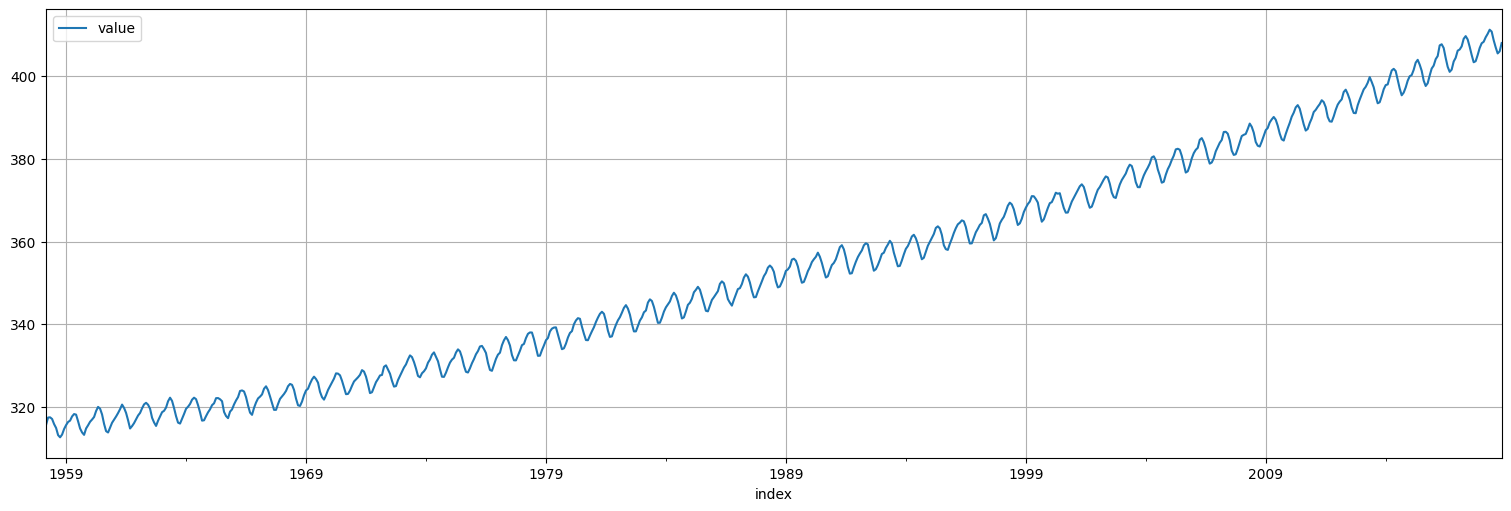

In [12]:
cardox = astsa.cardox
cardox.plot();

In [13]:
cardox.head()

,value
index,
1958-03,315.71
1958-04,317.45
1958-05,317.50
1958-06,317.10
1958-07,315.86


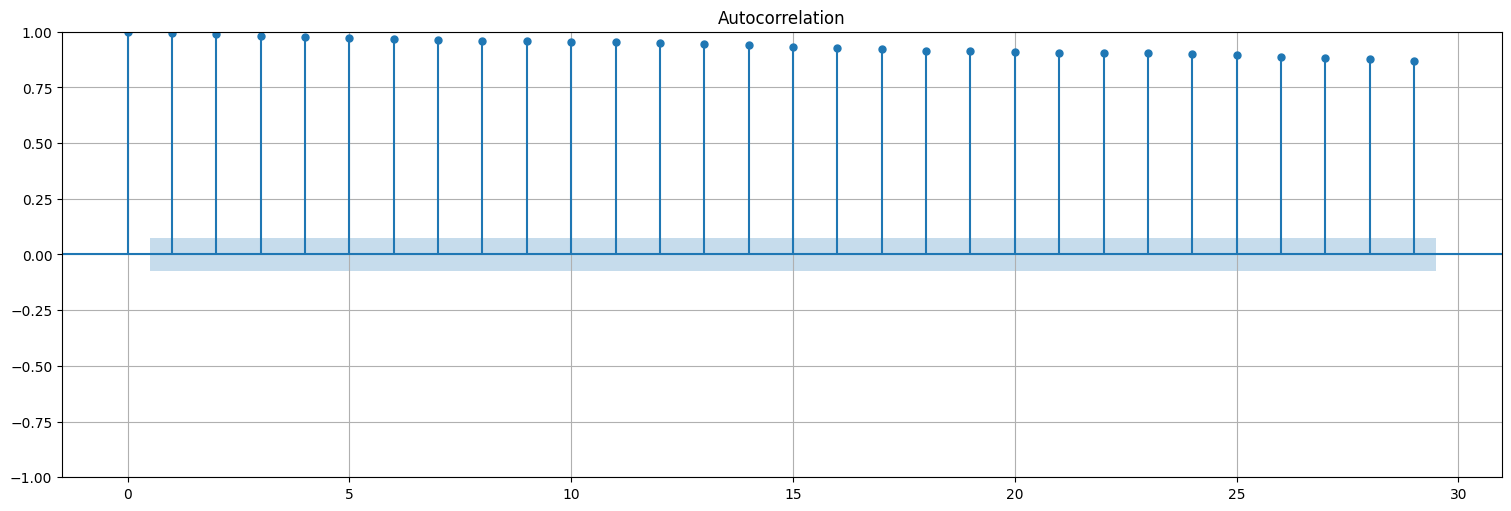

In [14]:
plot_acf(cardox,bartlett_confint=False);

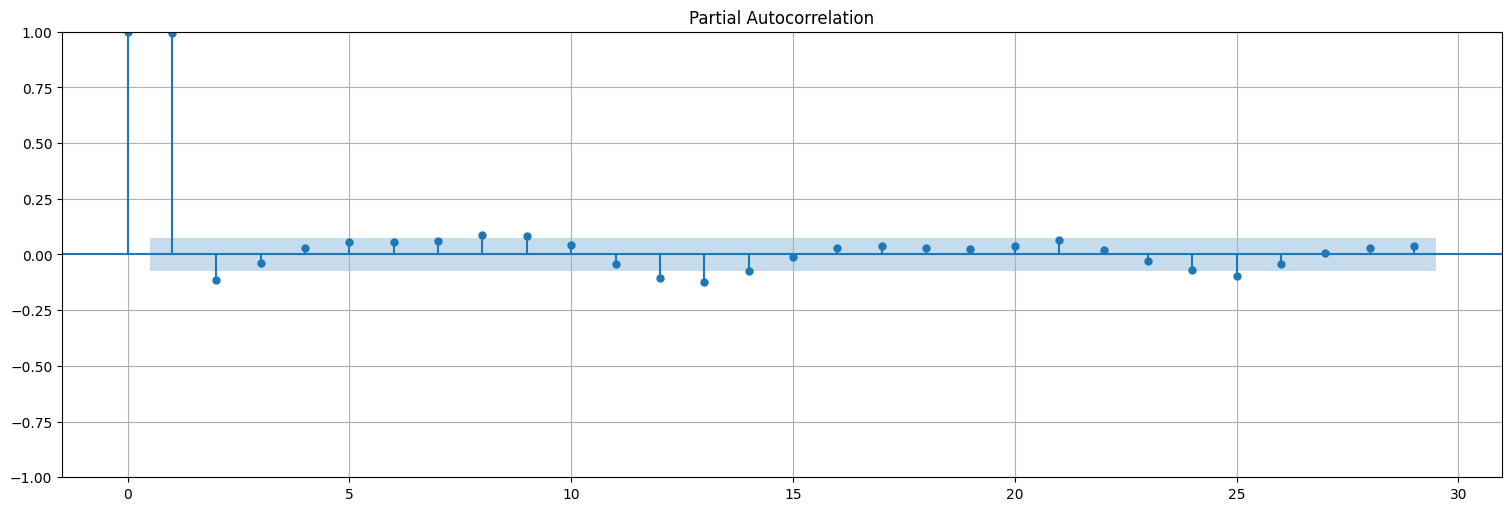

In [15]:
plot_pacf(cardox);

Parte 1

In [16]:
time = pd.Series([idx.ordinal for idx in cardox.index],index=cardox.index)
data = pd.concat([cardox,time],axis=1)
data.columns = ["cardox","time"]
cardoxfit_linear = smf.ols(formula="cardox ~ time", data=data).fit()
cardoxfit_linear_resid = cardoxfit_linear.resid
cardoxfit_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cardox   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 3.168e+04
Date:                Thu, 04 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:37:03   Log-Likelihood:                -2067.2
No. Observations:                 729   AIC:                             4138.
Df Residuals:                     727   BIC:                             4148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    325.0746      0.222   1462.357      0.000     324.638     325.511
time           0.1293      0.001    177.976      0.000       0.128       0.131
==============================================================================
Omnibus:                       33.937   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.757
Skew:                           0.532   Prob(JB):                     1.04e-08
Kurtosis:                       2.720   Cond. No.                         445.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

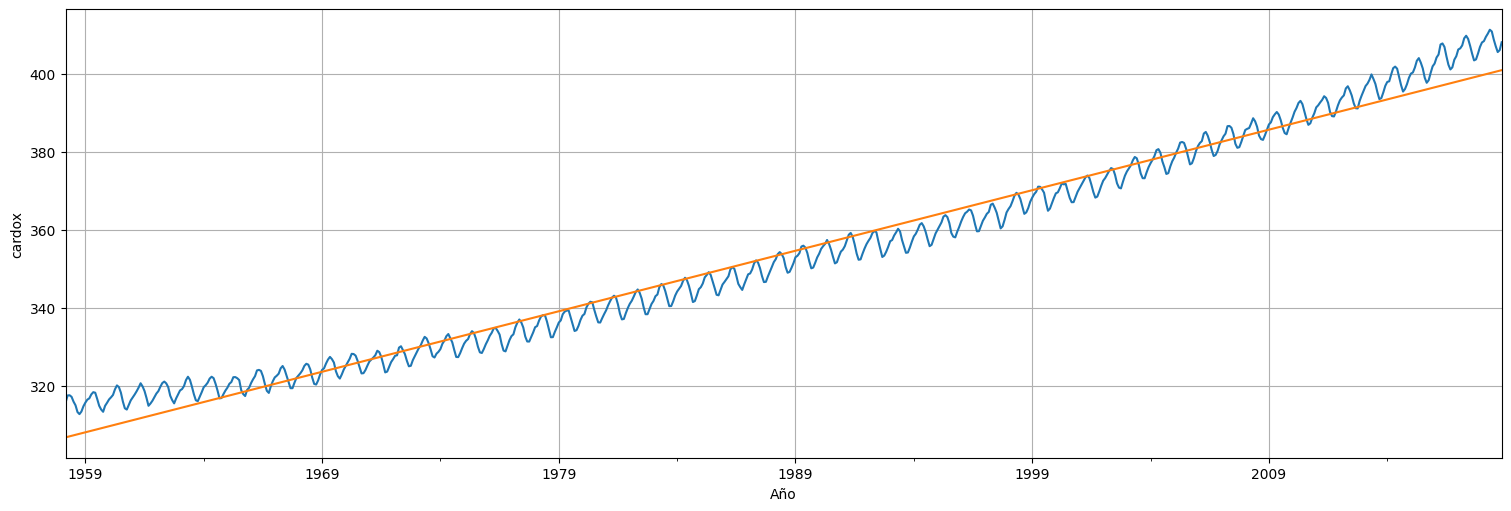

In [17]:
ax = cardox.plot(xlabel="Año", ylabel="cardox", legend=False)
ax.plot(cardoxfit_linear.fittedvalues);

In [ ]:
Hay una tendencia significativa ya que el p-valor es prácticamente 0 (y de esta forma se rechaza la hipótesis nula).
Aumenta en promedio 12% mensual

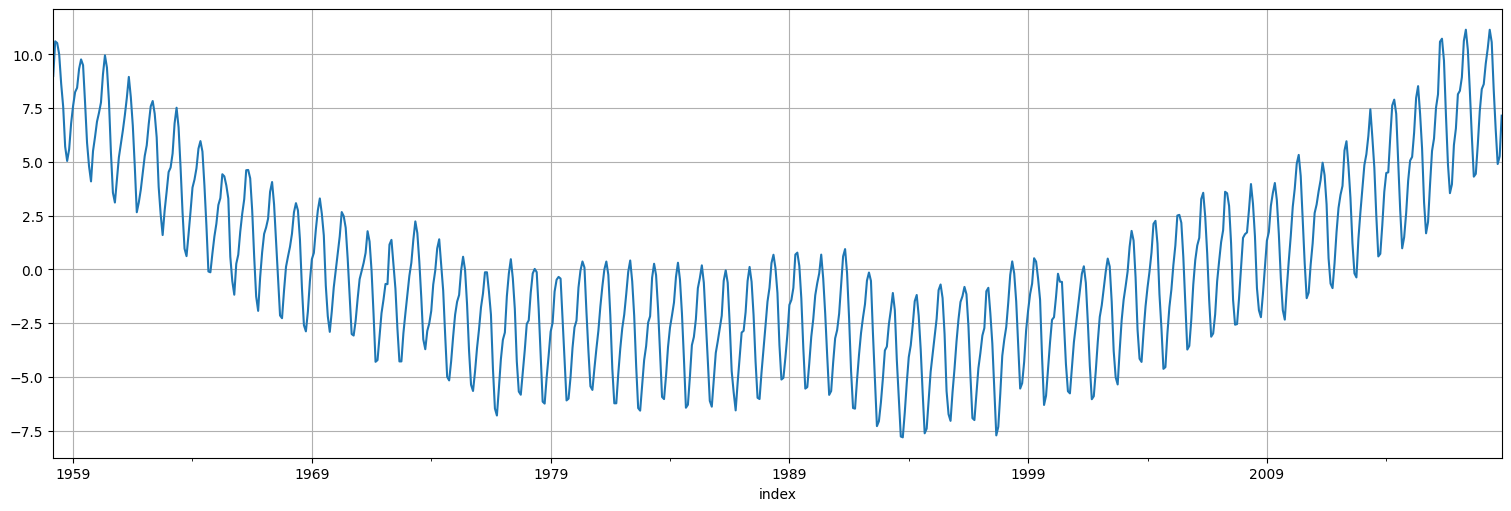

In [18]:
cardoxfit_linear_resid.plot();

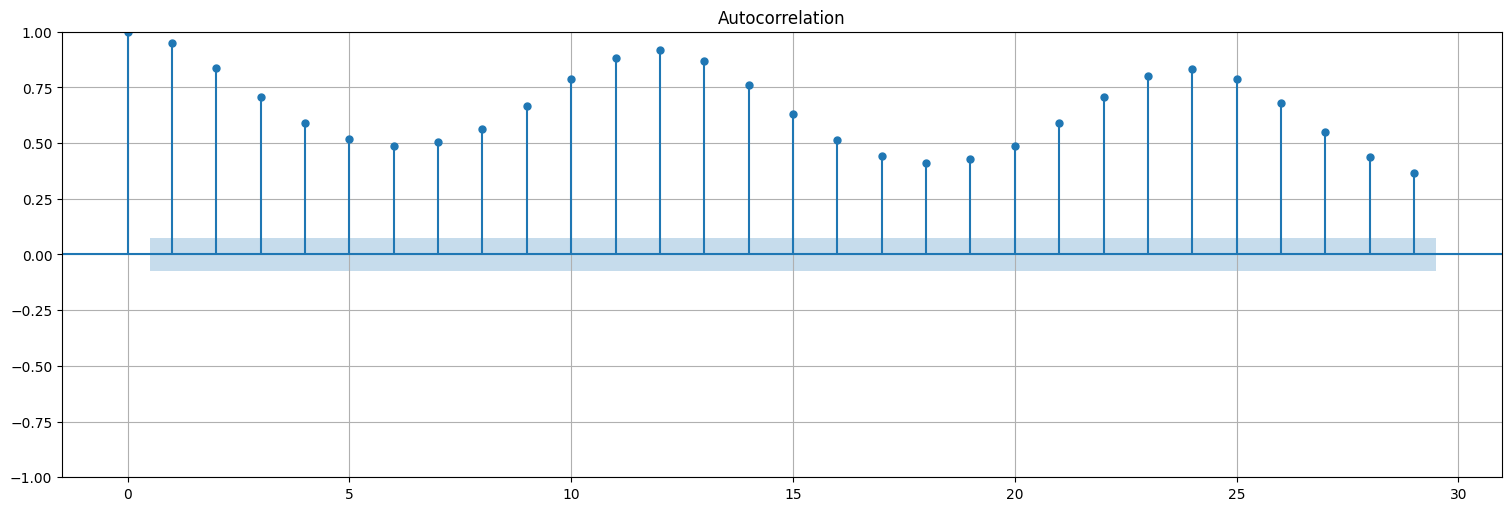

In [19]:
plot_acf(cardoxfit_linear_resid,bartlett_confint=False);

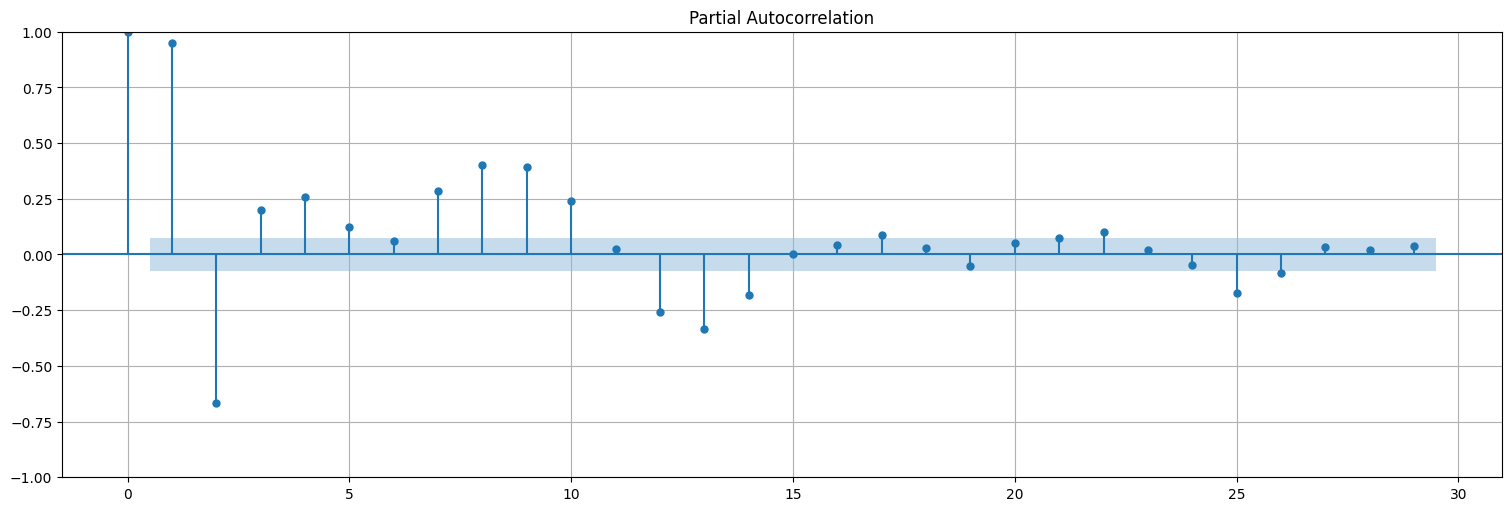

In [20]:
plot_pacf(cardoxfit_linear_resid);

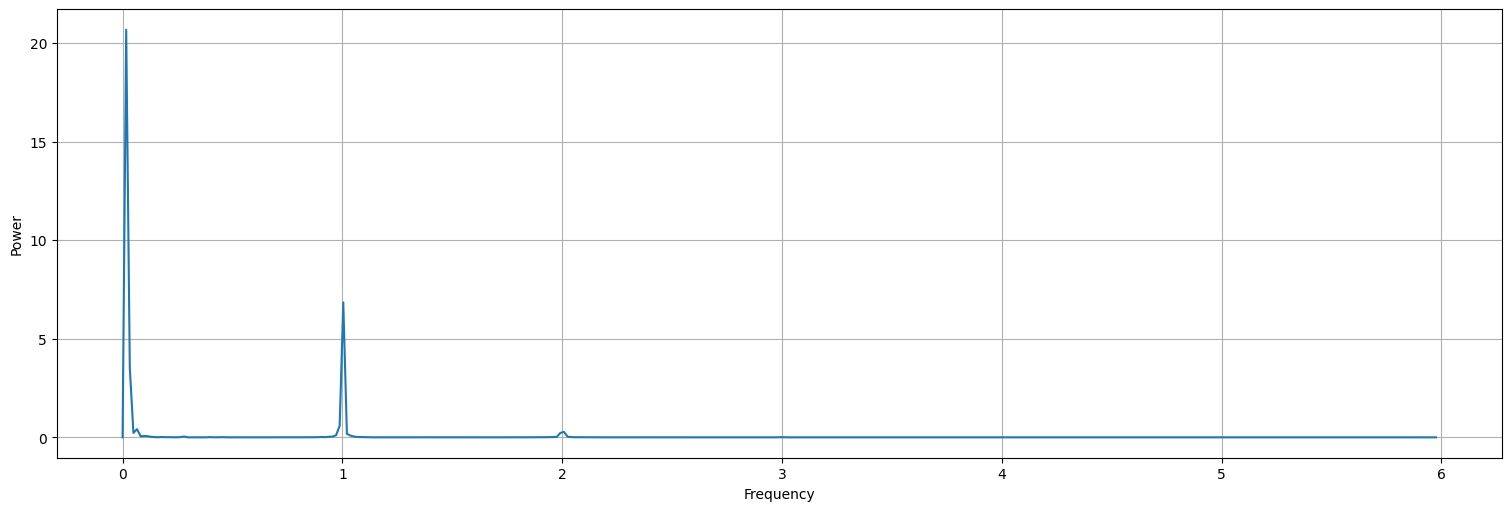

In [ ]:
periodogram(cardoxfit_linear_resid,sampling_frequency=12)

In [ ]:
spectrum(cardoxfit_linear_resid, sampling_frequency=12)

,Frecuencia,Potencia
0,0.016461,20.690398
1,1.004115,6.850596
2,0.032922,3.510883
3,0.987654,0.587140
4,0.065844,0.415409
5,2.008230,0.276692
6,1.991770,0.225894
7,0.049383,0.224369
8,1.020576,0.177726
9,0.971193,0.103252


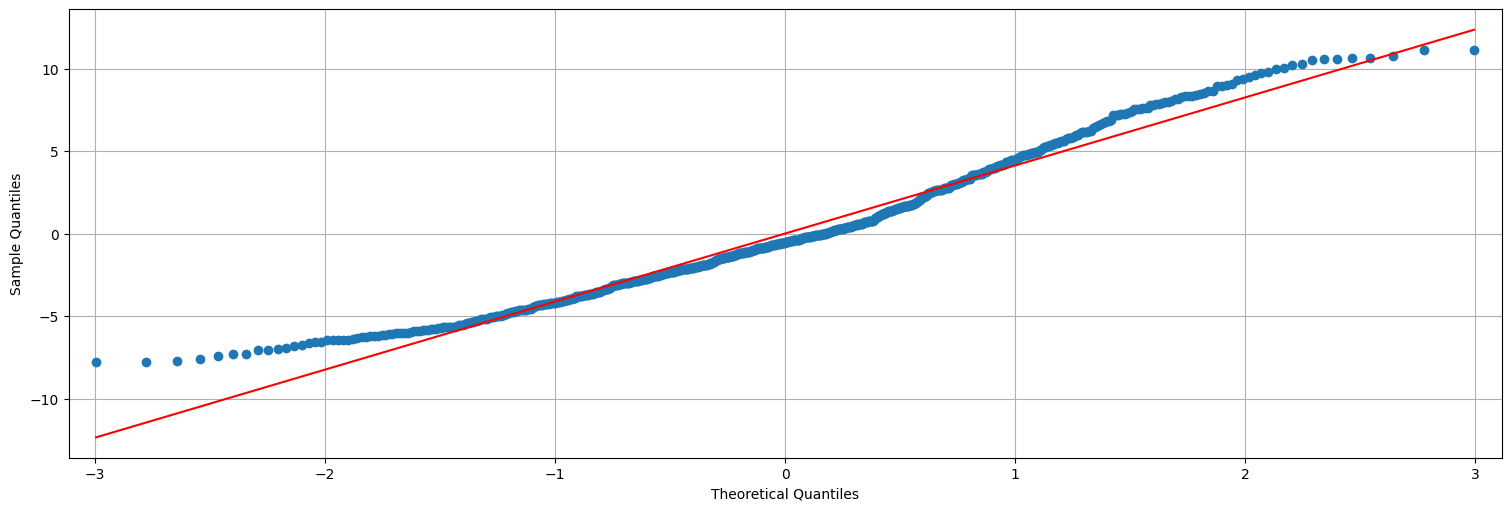

In [ ]:
sm.qqplot(cardoxfit_linear_resid, line="s");

Parte 2

In [31]:
#time  = time-np.mean(time)
time2 = time**2

datos = pd.concat([time, time2, cardox], axis=1)
datos.columns = ["time", "time2", "cardox"]

cardoxfit_linear_cuad = ols(formula="cardox ~ time + time2", data=datos).fit()
cardoxfit_linear_cuad_resid = cardoxfit_linear_cuad.resid
cardoxfit_linear_cuad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cardox   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 5.591e+04
Date:                Thu, 04 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:56:47   Log-Likelihood:                -1612.8
No. Observations:                 729   AIC:                             3232.
Df Residuals:                     726   BIC:                             3245.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    349.8958      0.123   2842.674      0.000     349.654     350.137
time           0.1293      0.000    331.693      0.000       0.129       0.130
time2       8.787e-05   2.07e-06     42.416      0.000    8.38e-05    9.19e-05
==============================================================================
Omnibus:                      110.611   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.547
Skew:                          -0.092   Prob(JB):                     1.04e-06
Kurtosis:                       2.066   Cond. No.                     8.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

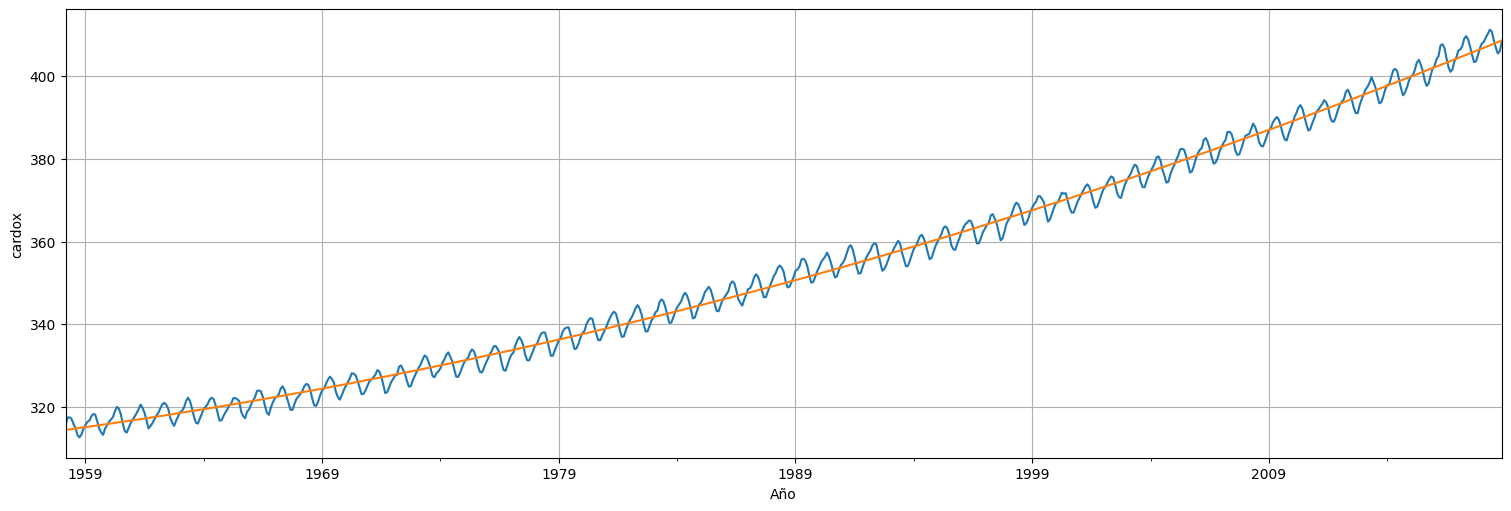

In [24]:
ax = cardox.plot(xlabel="Año", ylabel="cardox", legend=False)
ax.plot(cardoxfit_linear_cuad.fittedvalues);

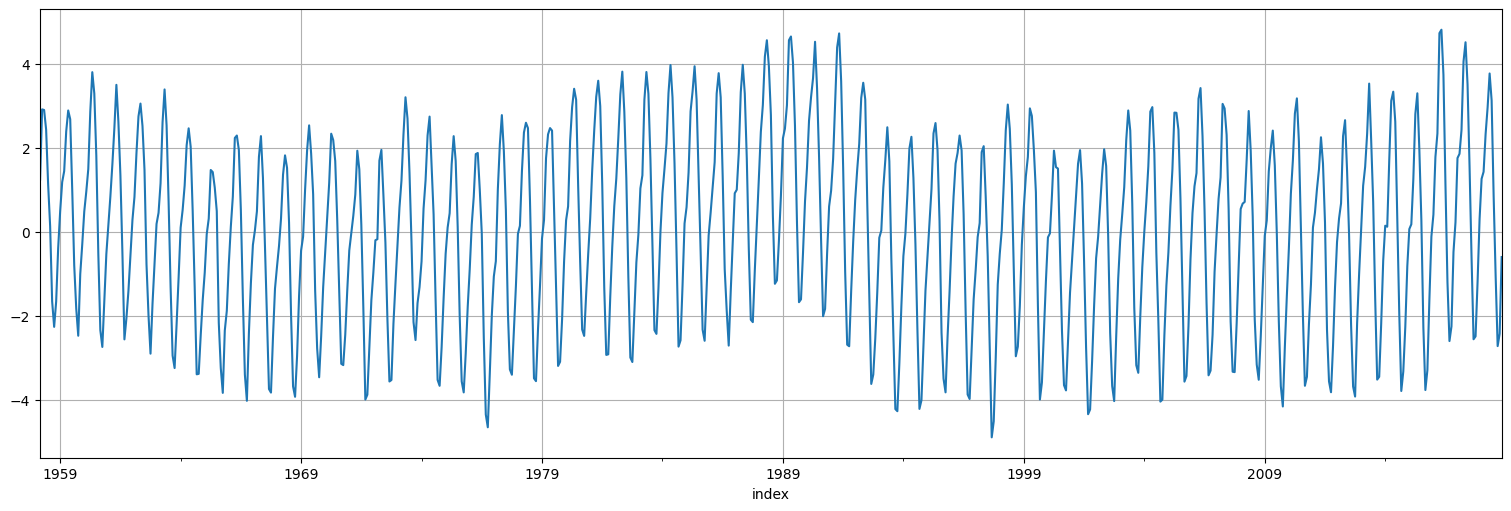

In [25]:
cardoxfit_linear_cuad_resid.plot();

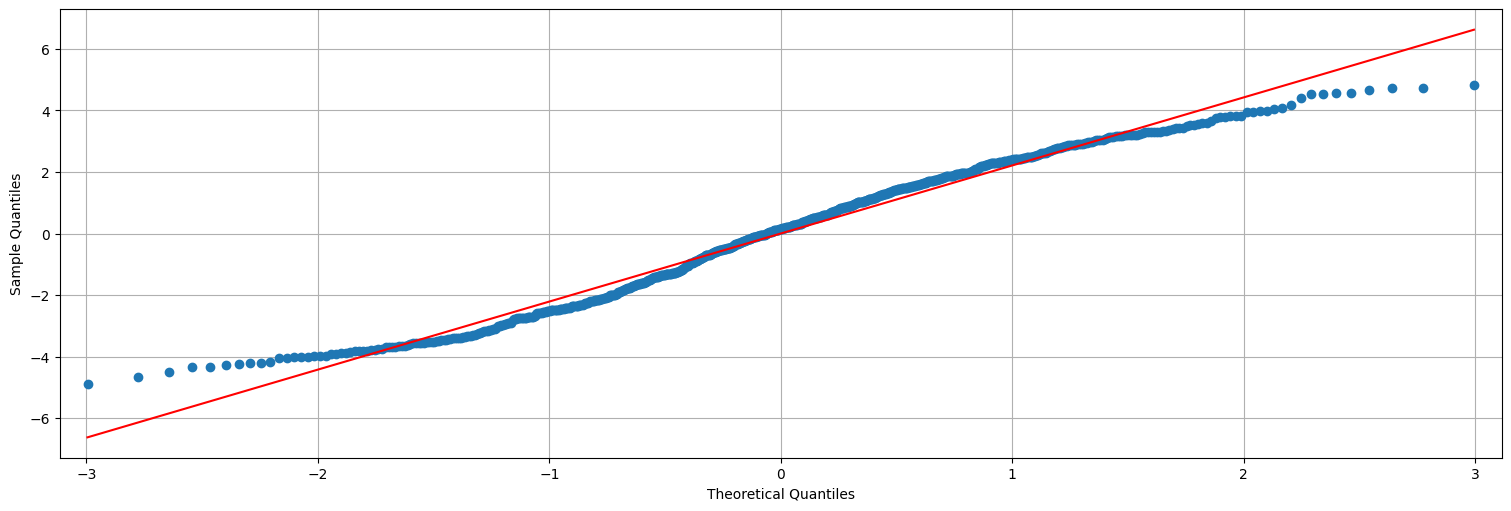

In [26]:
sm.qqplot(cardoxfit_linear_cuad_resid, line='s');

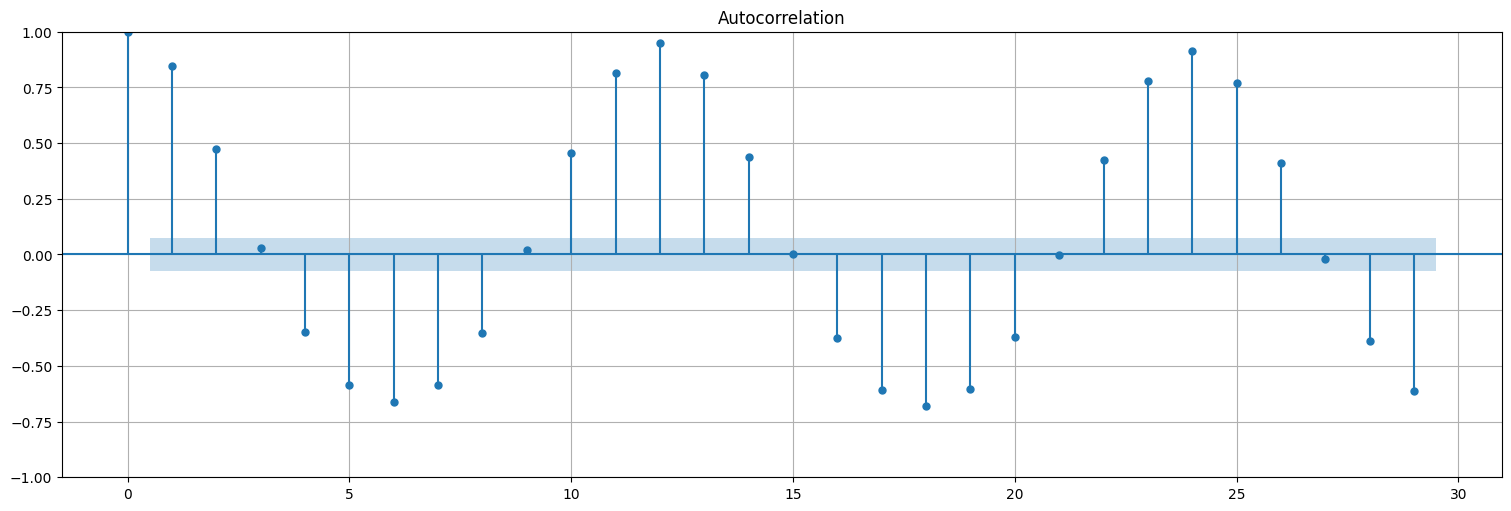

In [27]:
plot_acf(cardoxfit_linear_cuad_resid,bartlett_confint=False);

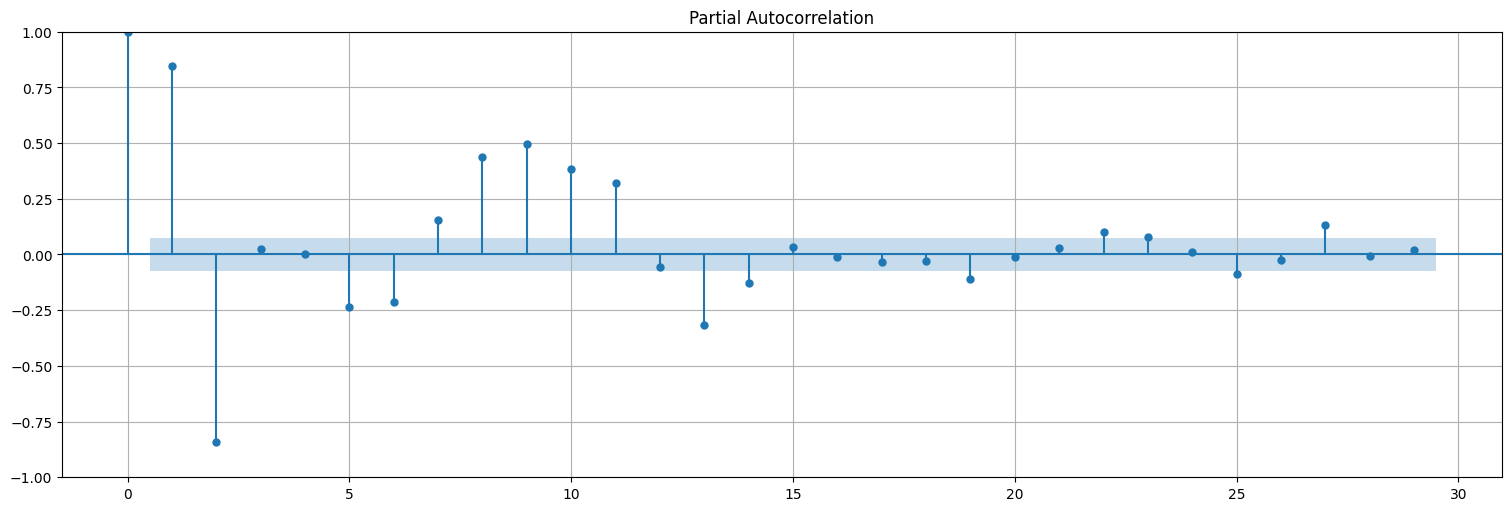

In [28]:
plot_pacf(cardoxfit_linear_cuad_resid);

Parte 3

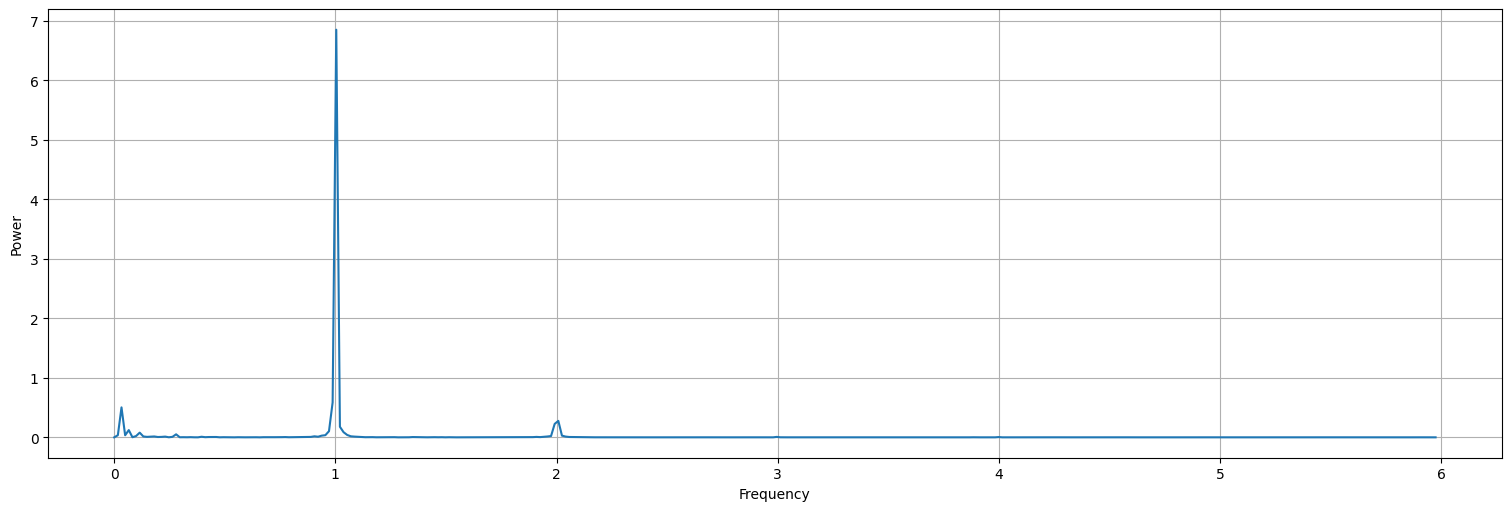

In [ ]:
periodogram(cardoxfit_linear_cuad_resid,sampling_frequency=12)

In [ ]:
spectrum(cardoxfit_linear_cuad_resid, sampling_frequency=12)

,Frecuencia,Potencia
0,1.004115,6.851430
1,0.987654,0.587196
2,0.032922,0.503610
3,2.008230,0.276524
4,1.991770,0.226001
5,1.020576,0.177790
6,0.065844,0.121813
7,0.971193,0.103334
8,1.037037,0.086701
9,0.115226,0.078760


Parte 4

In [33]:
time2 = time**2

datos = pd.concat([time, time2, cardox, cardox.shift(6), cardox.shift(12)], axis=1).dropna()
datos.columns = ["time", "time2", "cardox", "cardoxL6", "cardoxL12"]

cardoxfit_linear_cuad_lags = ols(formula="cardox ~ time + time2 + cardoxL6 + cardoxL12", data=datos).fit()
cardoxfit_linear_cuad_lags_resid = cardoxfit_linear_cuad_lags.resid
cardoxfit_linear_cuad_lags.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cardox   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.826e+05
Date:                Thu, 04 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:58:58   Log-Likelihood:                -637.54
No. Observations:                 717   AIC:                             1285.
Df Residuals:                     712   BIC:                             1308.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8410      8.569      4.416      0.000      21.017      54.665
time           0.0156      0.003      4.961      0.000       0.009       0.022
time2       9.251e-06   2.22e-06      4.172      0.000     4.9e-06    1.36e-05
cardoxL6      -0.0422      0.013     -3.137      0.002      -0.069      -0.016
cardoxL12      0.9380      0.013     69.747      0.000       0.912       0.964
==============================================================================
Omnibus:                        8.306   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.408
Skew:                           0.225   Prob(JB):                       0.0149
Kurtosis:                       3.280   Cond. No.                     2.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
Parte 5

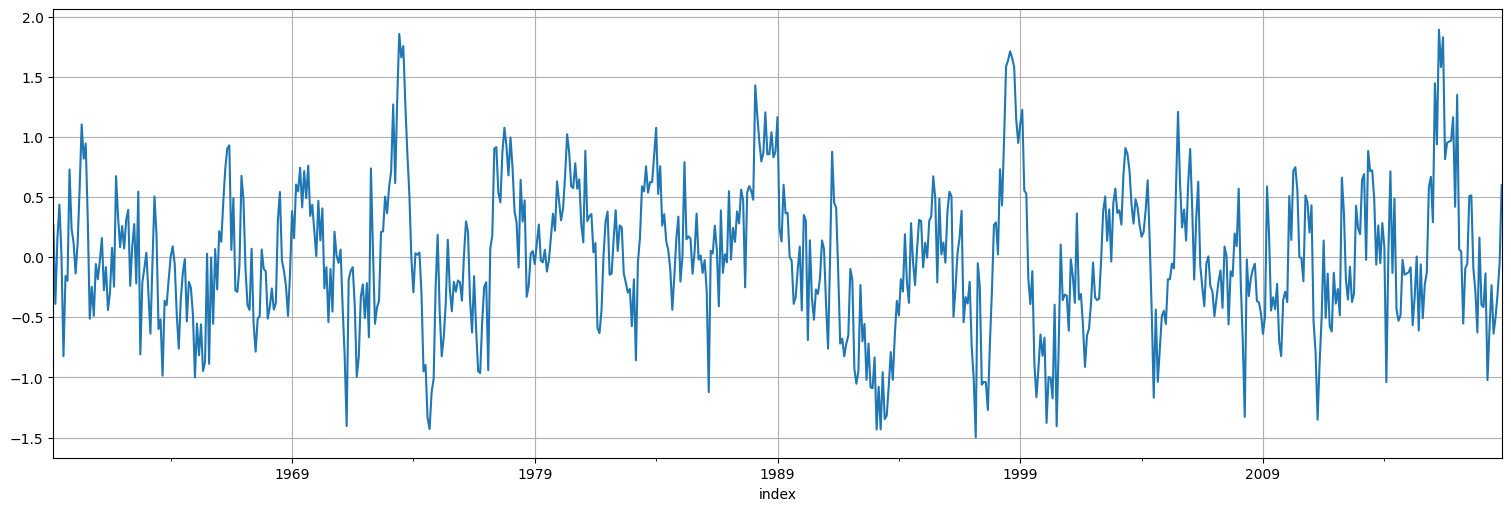

In [36]:
cardoxfit_linear_cuad_lags_resid.plot();

In [ ]:
No llega a ser ruido blanco, falta sacar información estacional de largo plazo y algún autorregresivo de orden 2 quizás

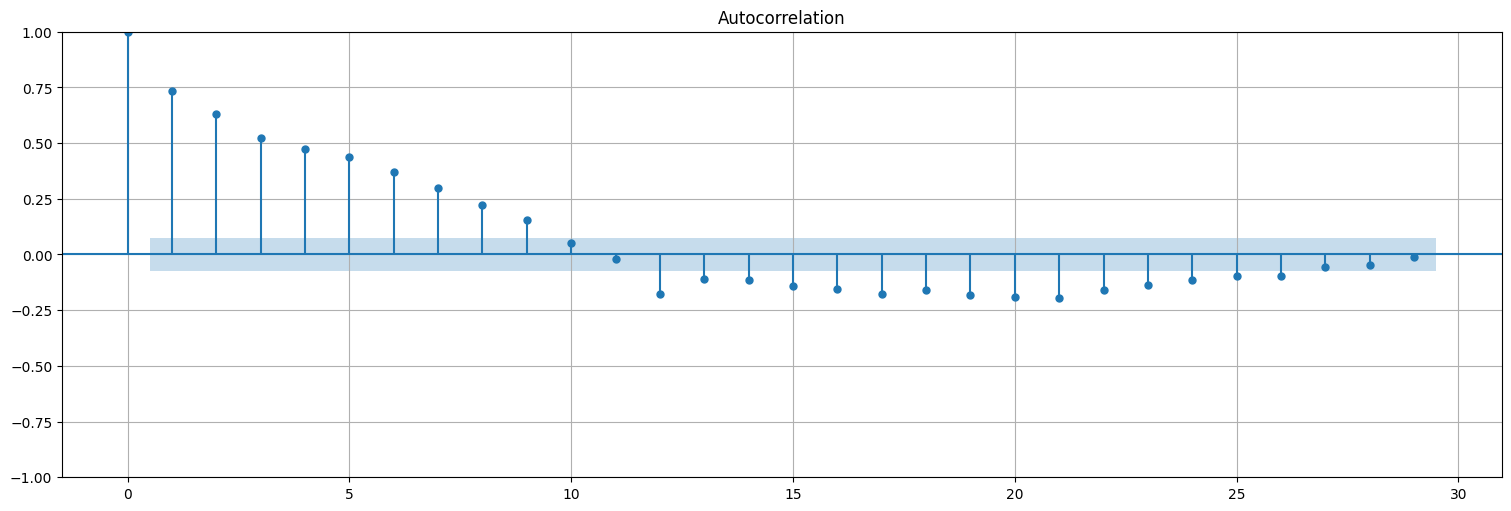

In [34]:
plot_acf(cardoxfit_linear_cuad_lags_resid,bartlett_confint=False);

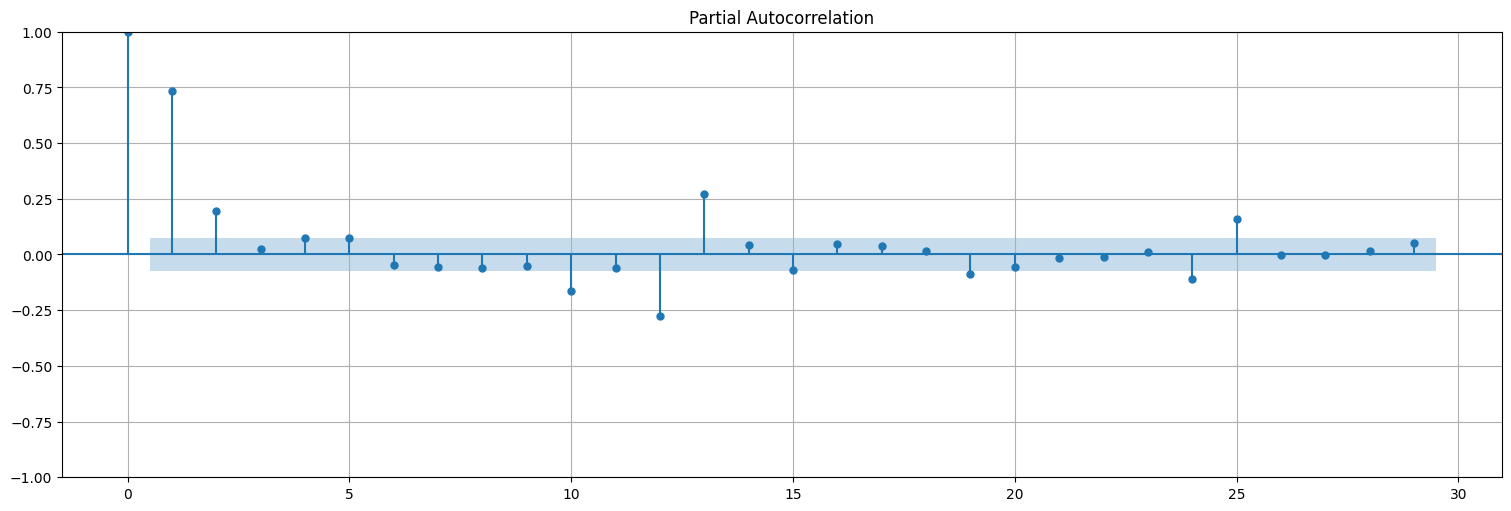

In [35]:
plot_pacf(cardoxfit_linear_cuad_lags_resid);

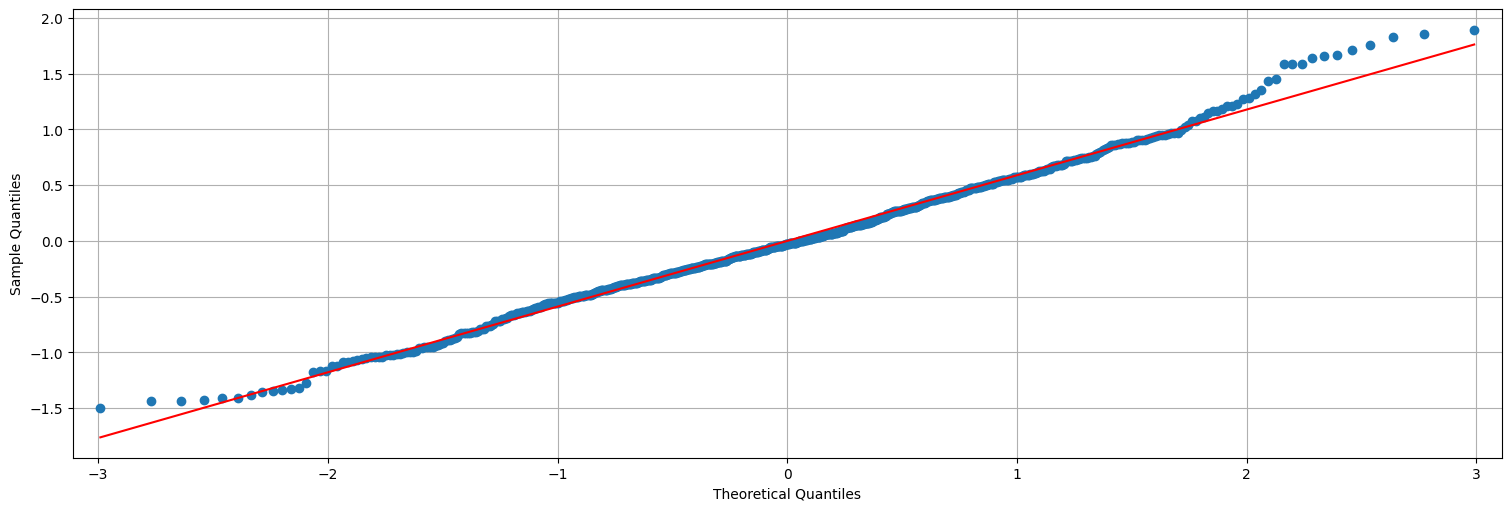

In [37]:
sm.qqplot(cardoxfit_linear_cuad_lags_resid, line='s');

In [ ]:
# Esto no aplica pero dejo código

In [ ]:
fit_ar2 = ARIMA(cardox,order=(2,0,0),trend='ct').fit()
fit_ar2_resid = fit_ar2.resid
fit_ar2.summary()

In [ ]:
fit_ar2.plot_diagnostics(lags=25);

In [ ]:
fit_ar2_i1 = ARIMA(cardox,order=(2,1,0),trend='n').fit()
fit_ar2_i1_resid = fit_ar2_i1.resid
fit_ar2_i1.summary()

In [ ]:
fit_sarima = ARIMA(cardox,order=(2,1,1), seasonal_order=(2, 1, 1, 12),trend="n").fit()
fit_sarima_resid = fit_sarima.resid
fit_sarima.summary()

### Ejercicio 2

Se considera la serie `Nile` incluida con `R` con las medidas anuales de flujo en unidades de $10^8 m^3$ sobre la represa de Asswan.

1. Discutir brevemente si la serie es estacionaria.
2. Realizar un análisis de la autocorrelación y autocorrelación parcial.
3. Realizar un ajuste a un modelo $ARMA(p,q)$ adecuado. Puede incorporar dos modelos para comparar.
4. Analizar los residuos resultantes.
5. Realizar una predicción a 5 años hacia adelante.

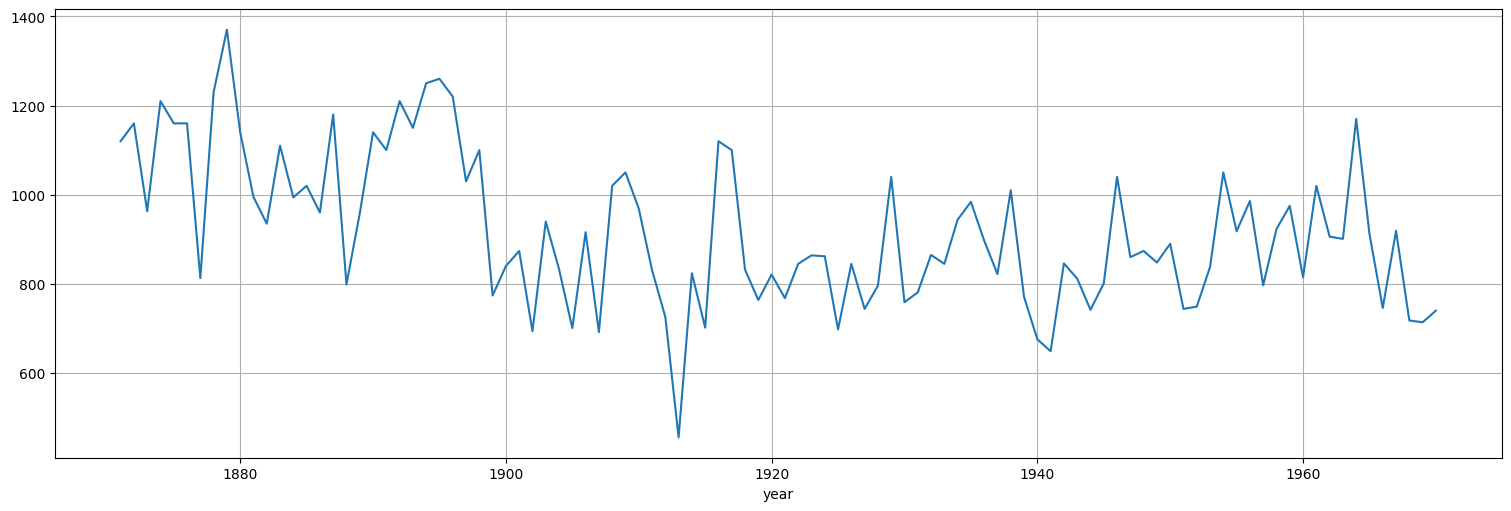

In [38]:
nile = sm.datasets.nile.load()
nile = pd.Series(nile["data"]["volume"].values, index=nile["data"]["year"])
nile.plot();

In [40]:
nile.head()

year
1871.0    1120.0
1872.0    1160.0
1873.0     963.0
1874.0    1210.0
1875.0    1160.0
dtype: float64

Parte 1
La serie no parece ser estacionaria. Si se hiciera una recta de regresión lineal, la misma tendría tendencia negativa con el tiempo

Parte 2

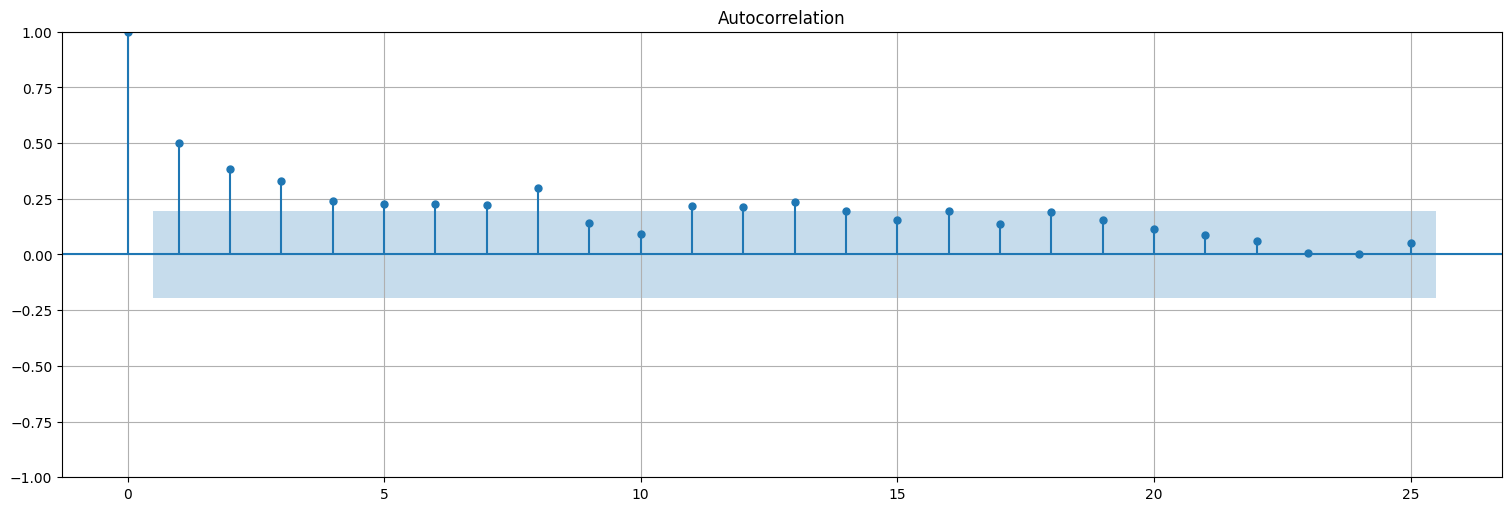

In [ ]:
plot_acf(nile,bartlett_confint=False,lags=25);

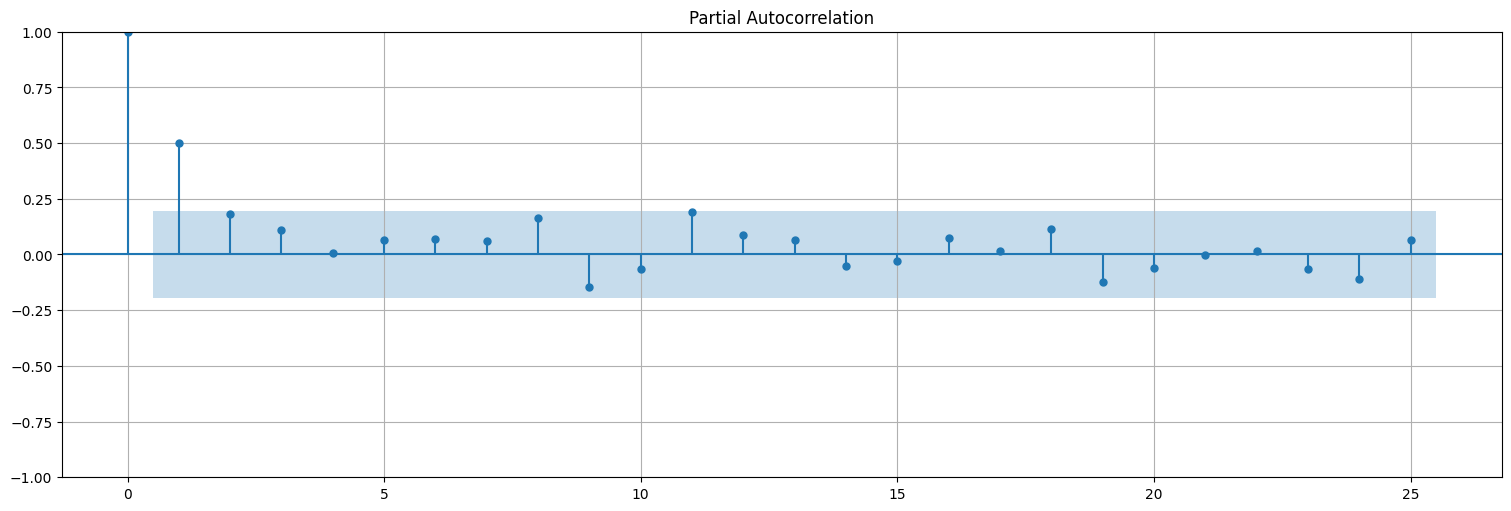

In [ ]:
plot_pacf(nile,lags=25);

In [ ]:
Dado que la ACF cae lentamente y la PACF corta en el lag 1, se puede asumir que se podría hacer un AR(1) o probar con alguna combinación de AR y MA

Parte 3

In [49]:
fitar1 = ARIMA(nile,order=(1,0,0), trend="ct").fit()
fitar1_resid = fitar1.resid
fitar1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -634.791
Date:                Thu, 04 Jul 2024   AIC                           1277.582
Time:                        16:18:57   BIC                           1288.003
Sample:                             0   HQIC                          1281.800
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1056.5320     42.573     24.817      0.000     973.090    1139.974
x1            -2.7239      0.805     -3.382      0.001      -4.302      -1.145
ar.L1          0.3723      0.095      3.913      0.000       0.186       0.559
sigma2      1.908e+04   2879.828      6.624      0.000    1.34e+04    2.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.65   Prob(JB):                         0.94
Heteroskedasticity (H):               0.66   Skew:                            -0.07
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
fitar1i1 = ARIMA(nile,order=(0,0,1), trend="ct").fit()
fitar1i1_resid = fitar1i1.resid
fitar1i1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -636.598
Date:                Thu, 04 Jul 2024   AIC                           1281.196
Time:                        16:17:14   BIC                           1291.617
Sample:                             0   HQIC                          1285.413
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1056.4580     35.791     29.517      0.000     986.309    1126.607
x1            -2.7177      0.678     -4.009      0.000      -4.046      -1.389
ma.L1          0.2987      0.092      3.255      0.001       0.119       0.479
sigma2      1.979e+04   2893.162      6.841      0.000    1.41e+04    2.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.58   Prob(JB):                         0.86
Heteroskedasticity (H):               0.65   Skew:                            -0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
fitar1i1m1 = ARIMA(nile,order=(1,0,1), trend="ct").fit()
fitar1i1m1_resid = fitar1i1m1.resid
fitar1i1m1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -633.811
Date:                Thu, 04 Jul 2024   AIC                           1277.622
Time:                        16:17:50   BIC                           1290.648
Sample:                             0   HQIC                          1282.894
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1056.6254     52.218     20.235      0.000     954.280    1158.971
x1            -2.7389      0.985     -2.781      0.005      -4.669      -0.809
ar.L1          0.6758      0.166      4.082      0.000       0.351       1.000
ma.L1         -0.3608      0.220     -1.640      0.101      -0.792       0.070
sigma2      1.869e+04   2814.204      6.641      0.000    1.32e+04    2.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.97   Prob(JB):                         0.97
Heteroskedasticity (H):               0.65   Skew:                            -0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

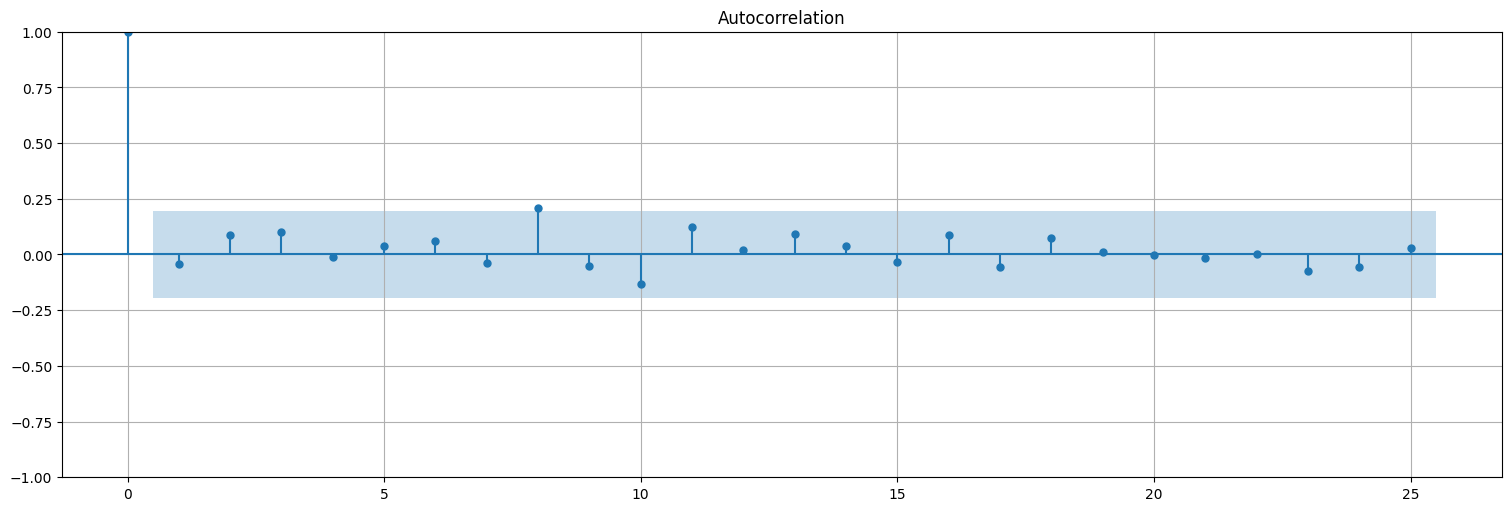

In [50]:
plot_acf(fitar1_resid,bartlett_confint=False,lags=25);

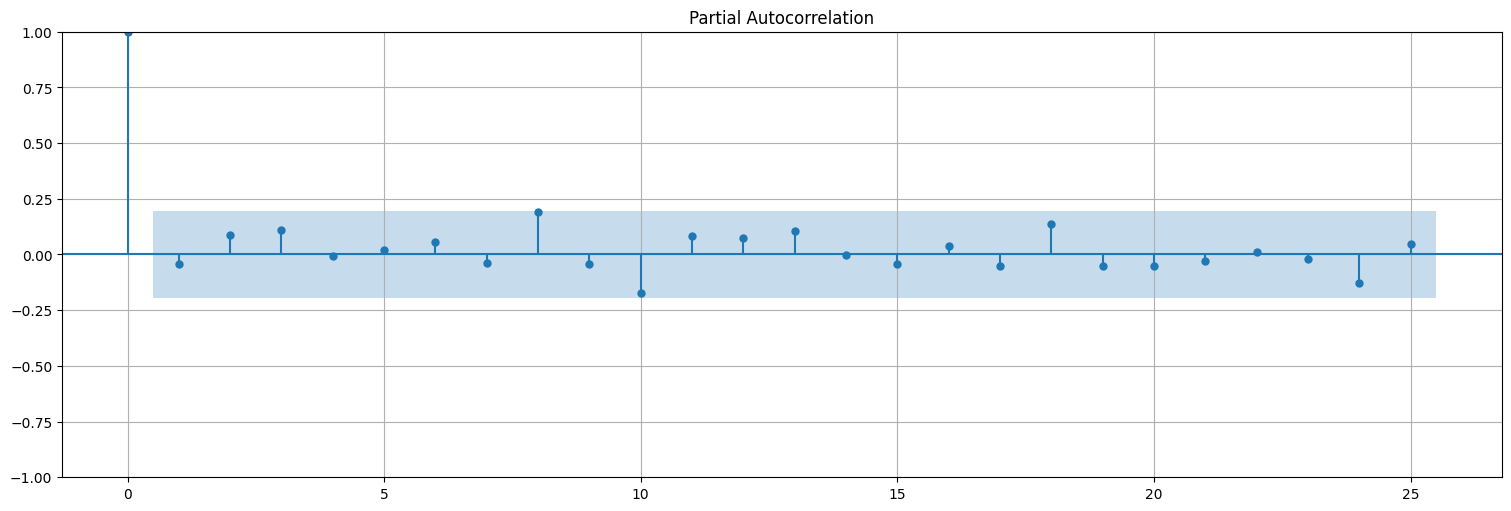

In [51]:
plot_pacf(fitar1_resid,lags=25);

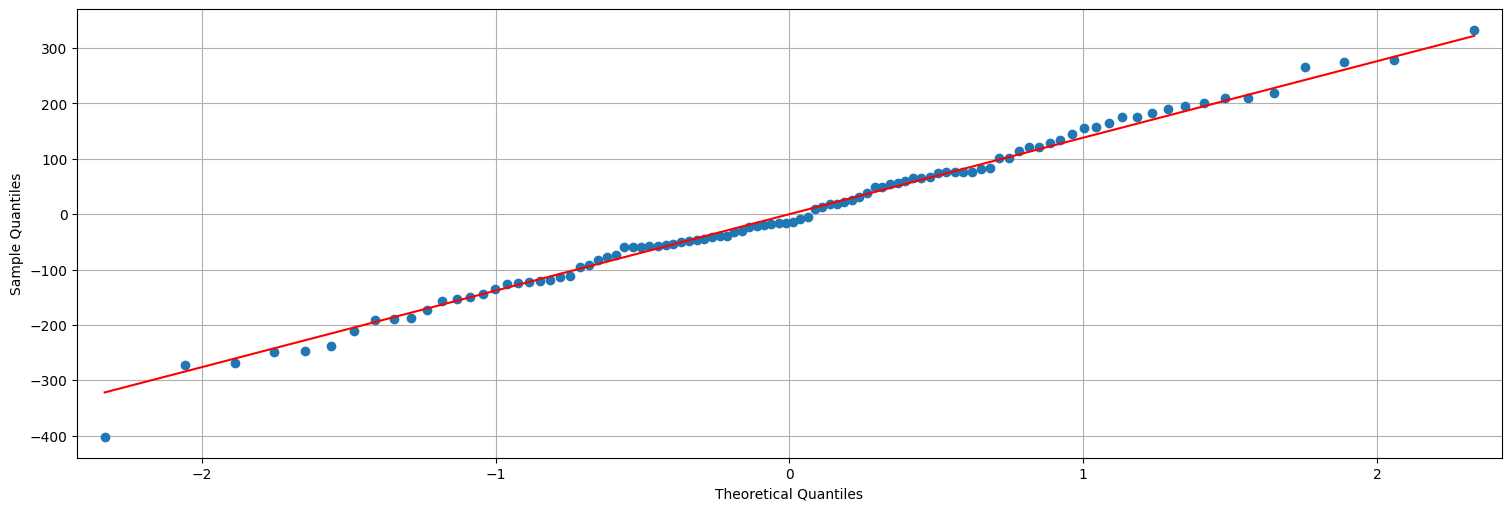

In [52]:
sm.qqplot(fitar1_resid, line='s');

In [ ]:
El modelo ARMA(1,0) parece ser el que mejor ajusta la serie

### Ejercicio 3

Se considera la serie $x$ de niveles de $CO$, así como la serie $y$ de mortalidad semanal por causas respiratorias. Ambas son parte del objeto `lap` de la biblioteca `astsa`. Ambas series comienzan en $1970$ y tienen una frecuencia semanal (`freq=52`).

1. Analice la correlación cruzada entre ambas series.
2. ¿Para que valor de lag se da la mayor correlación entre ambas?
3. Se propone un modelo de la forma $y_t = \beta_0 + \beta_1 x_{t-l} + w_t$ con $x$ e $y$ como antes y $l$ el lag de la parte anterior. Realice un ajuste lineal para estimar los parámetros $\beta_0$ y $\beta_1$.
4. ¿Cuánto de la varianza de la serie original se explica por la relación entre $x$ e $y$?
5. Realice un gráfico de la predicción del modelo (no olvide que la primera predicción será luego de $l$ lags) y la mortalidad observada.
6. Analice los residuos del modelo y discuta si aún queda información por ajustar.

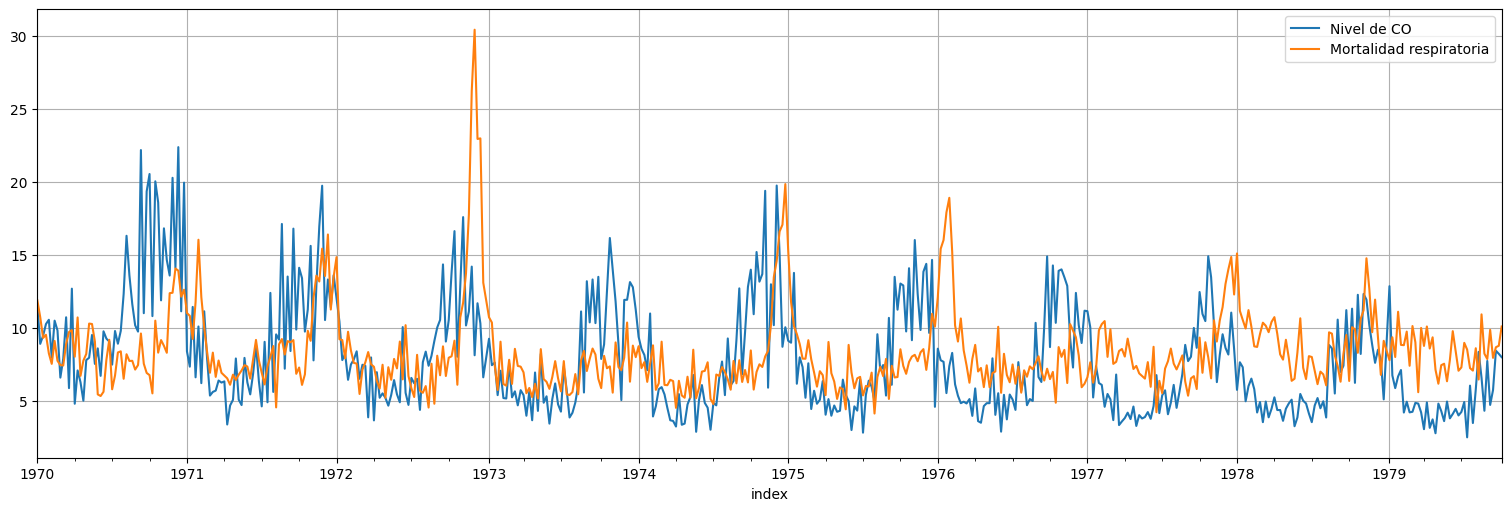

In [58]:
co = astsa.lap["co"]
rmort = astsa.lap["rmort"]

co.plot(label="Nivel de CO");
rmort.plot(label="Mortalidad respiratoria");
plt.legend();

In [59]:
co.head()

index
1969-12-29/1970-01-04    11.51
1970-01-05/1970-01-11     8.92
1970-01-12/1970-01-18     9.48
1970-01-19/1970-01-25    10.28
1970-01-26/1970-02-01    10.57
Freq: W-SUN, Name: co, dtype: float64

In [60]:
rmort.head()

index
1969-12-29/1970-01-04    11.90
1970-01-05/1970-01-11    10.75
1970-01-12/1970-01-18     9.33
1970-01-19/1970-01-25     9.54
1970-01-26/1970-02-01     8.27
Freq: W-SUN, Name: rmort, dtype: float64

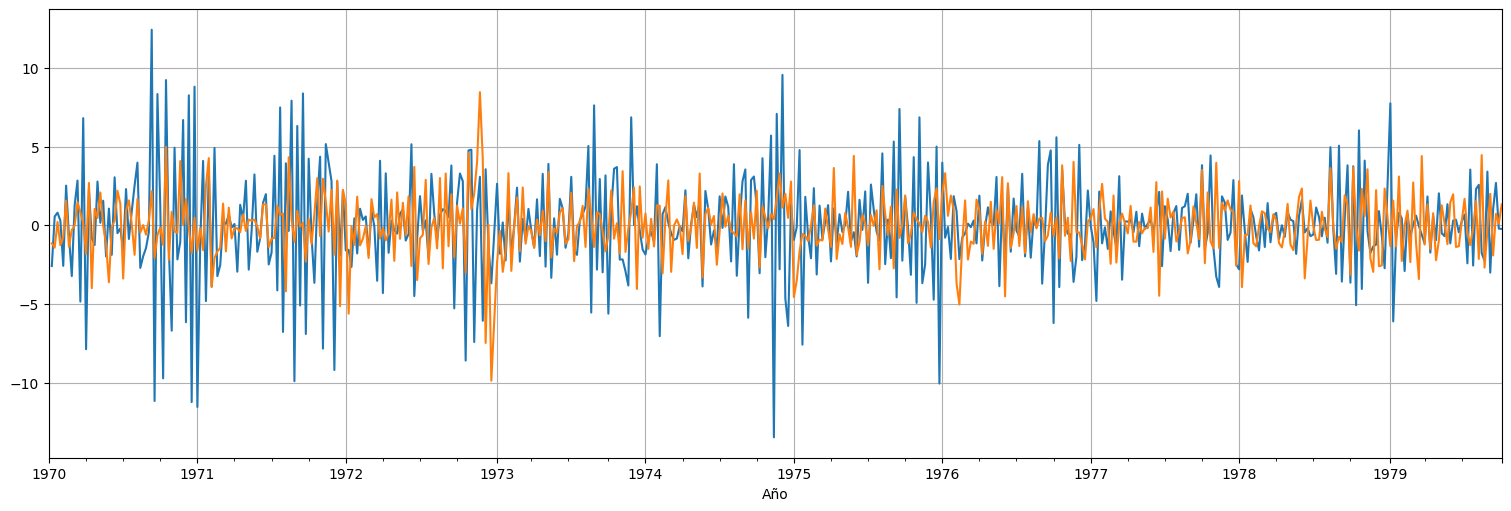

In [91]:
codiff = co.diff()
rmortdiff = rmort.diff()
ax = codiff.plot(xlabel="Año", legend=False)
rmortdiff.plot(ax=ax, xlabel="Año", legend=False);

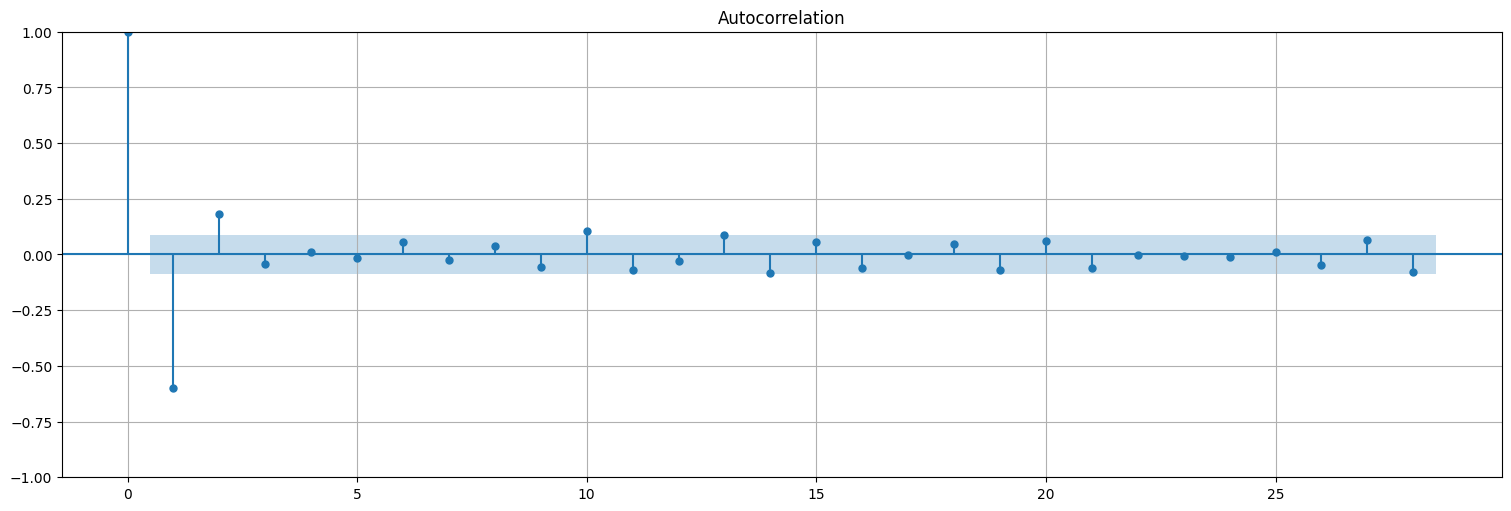

In [92]:
plot_acf(codiff.dropna(),bartlett_confint=False);

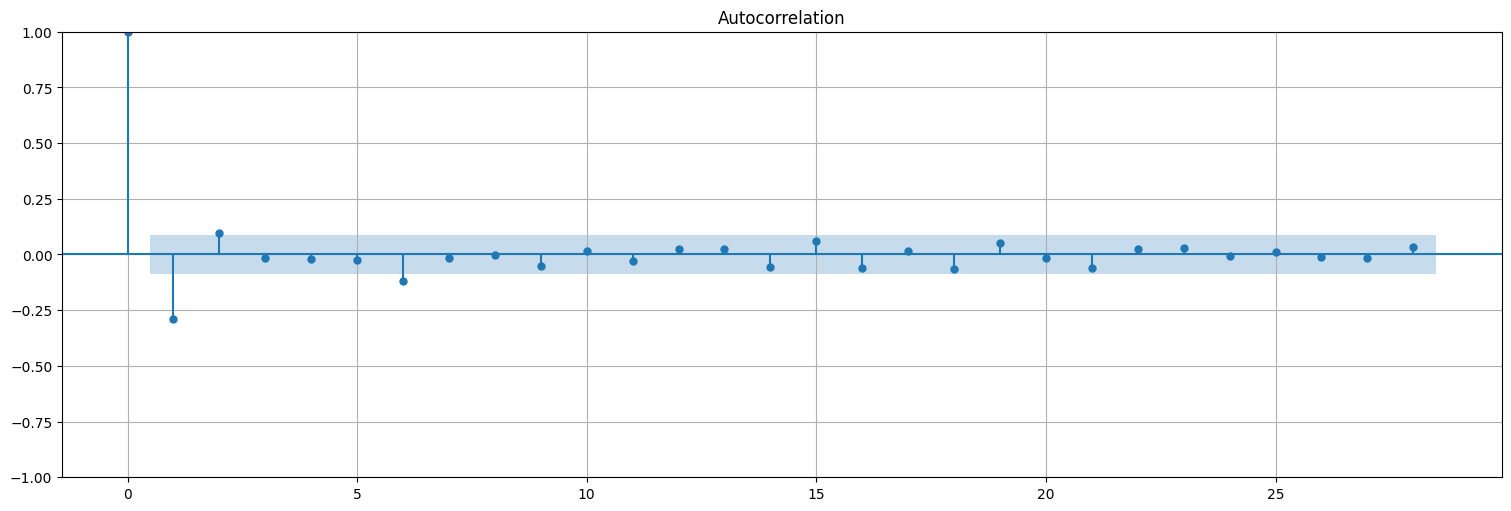

In [94]:
plot_acf(rmortdiff.dropna(),bartlett_confint=False);

In [ ]:
Parte 1

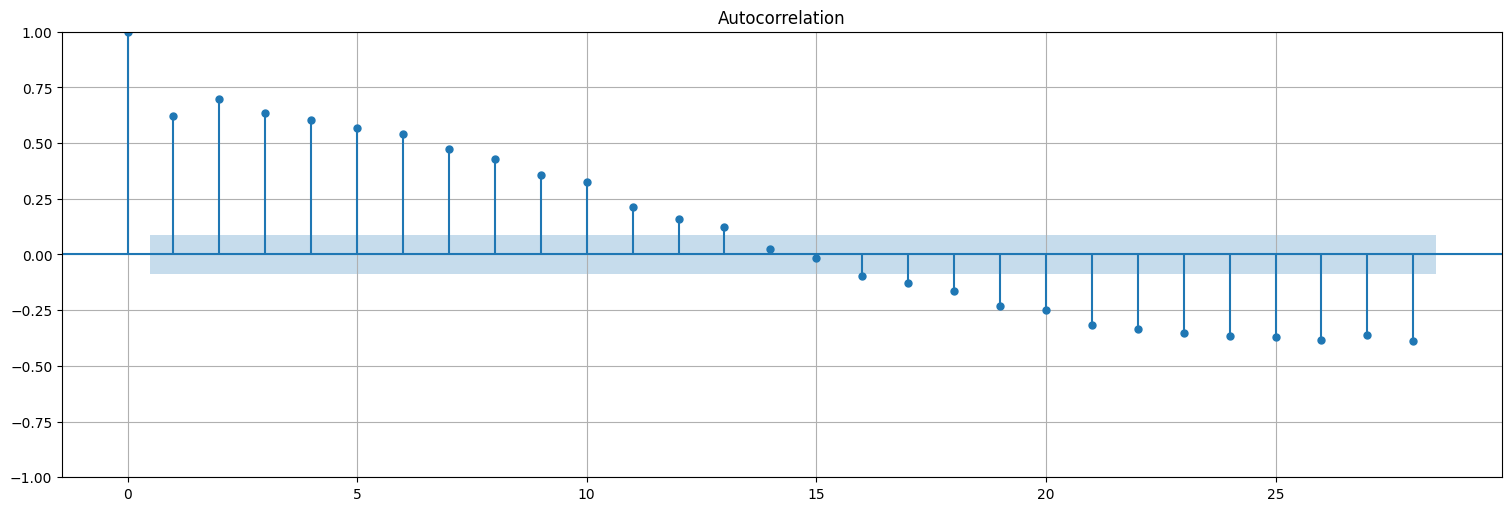

In [61]:
plot_acf(co, bartlett_confint=False);

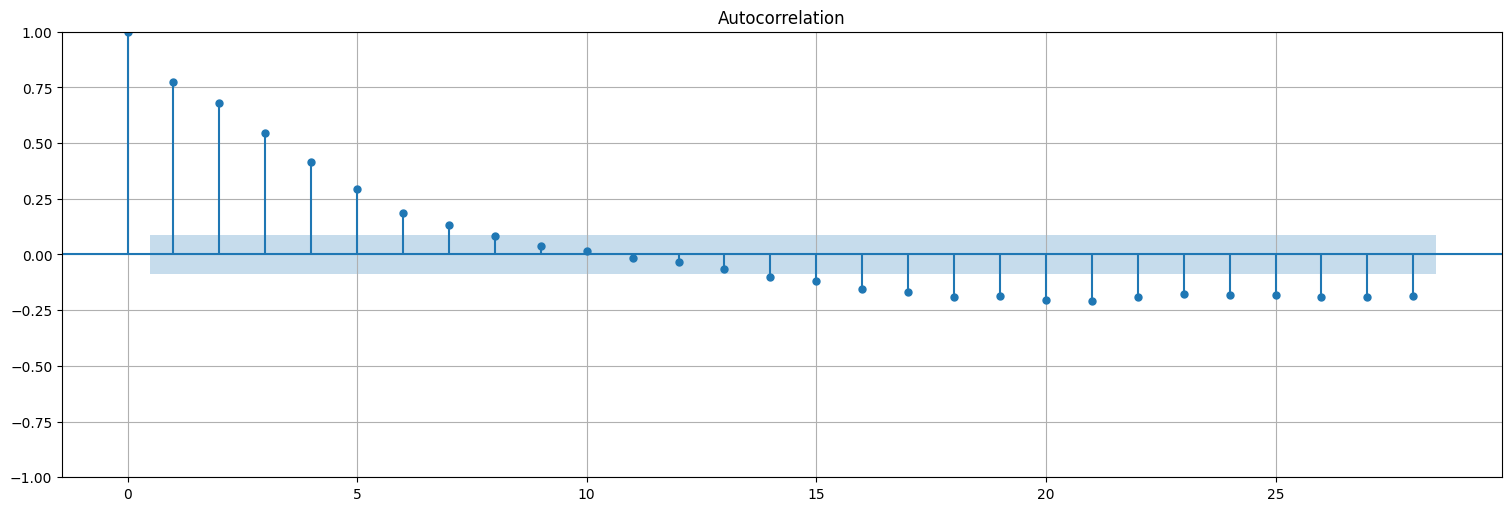

In [62]:
plot_acf(rmort, bartlett_confint=False);

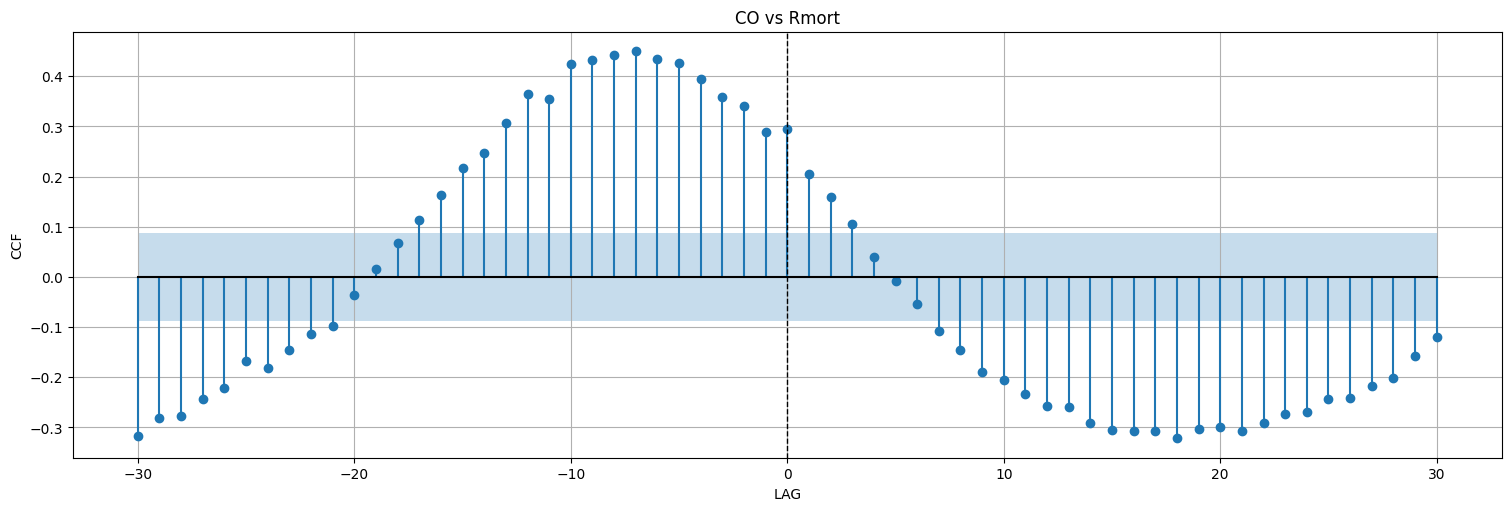

In [63]:
ccf(co,rmort, max_lag=30)
plt.title("CO vs Rmort");

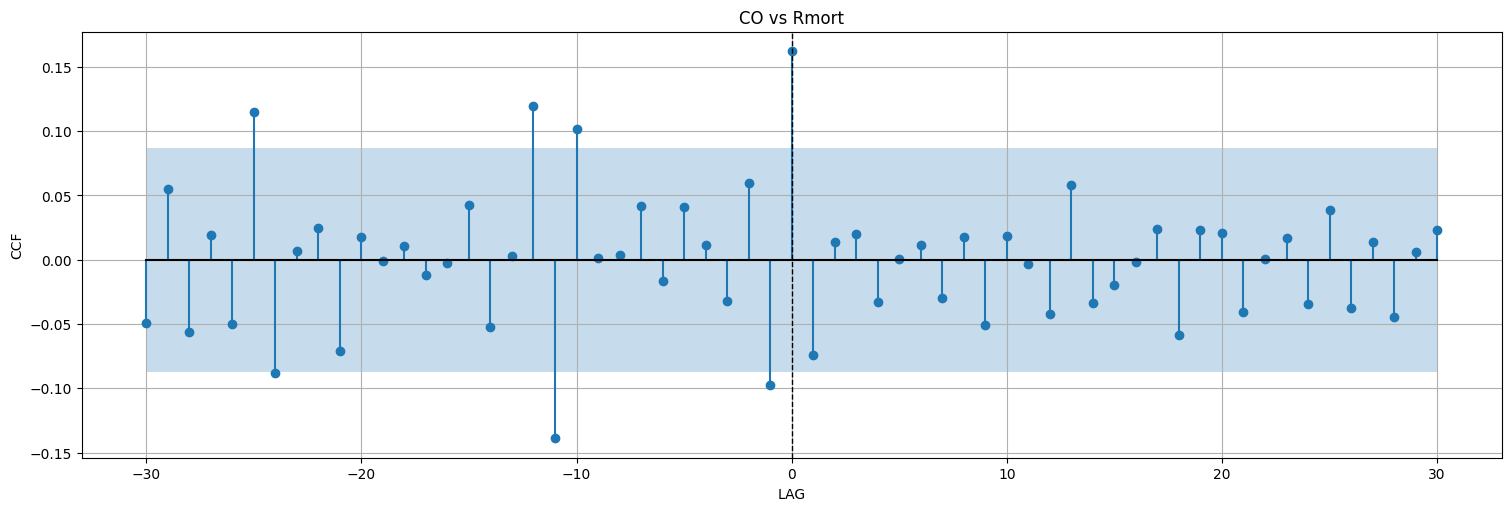

In [100]:
ccf(codiff.dropna(),rmortdiff.dropna(), max_lag=30)
plt.title("CO vs Rmort");

In [ ]:
Parte 2

In [ ]:
En el lag -6 (o -7) es donde se da la mayor correlación entre ambas series y se puede decir que cuando baja el CO, la mortalidad disminuye.
Además, la serie CO anticipa la serie Rmort por varios meses, lo que indica que se puede predecir la serie Rmort con un lag de 6 meses o 7
Hay mucha correlación entre ambas series

In [ ]:
Parte 3

In [83]:
datos = pd.concat([rmort, co.shift(7)], axis=1).dropna()
datos.columns = ["rmort", "coL7"]

rmortfit = ols(formula="rmort ~ coL7", data=datos).fit()
rmortfit_resid = rmortfit.resid
rmortfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rmort   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     128.4
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           1.22e-26
Time:                        17:00:48   Log-Likelihood:                -1182.8
No. Observations:                 501   AIC:                             2370.
Df Residuals:                     499   BIC:                             2378.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6412      0.267     21.136      0.000       5.117       6.166
coL7           0.3444      0.030     11.330      0.000       0.285       0.404
==============================================================================
Omnibus:                      298.083   Durbin-Watson:                   0.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3407.417
Skew:                           2.392   Prob(JB):                         0.00
Kurtosis:                      14.846   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

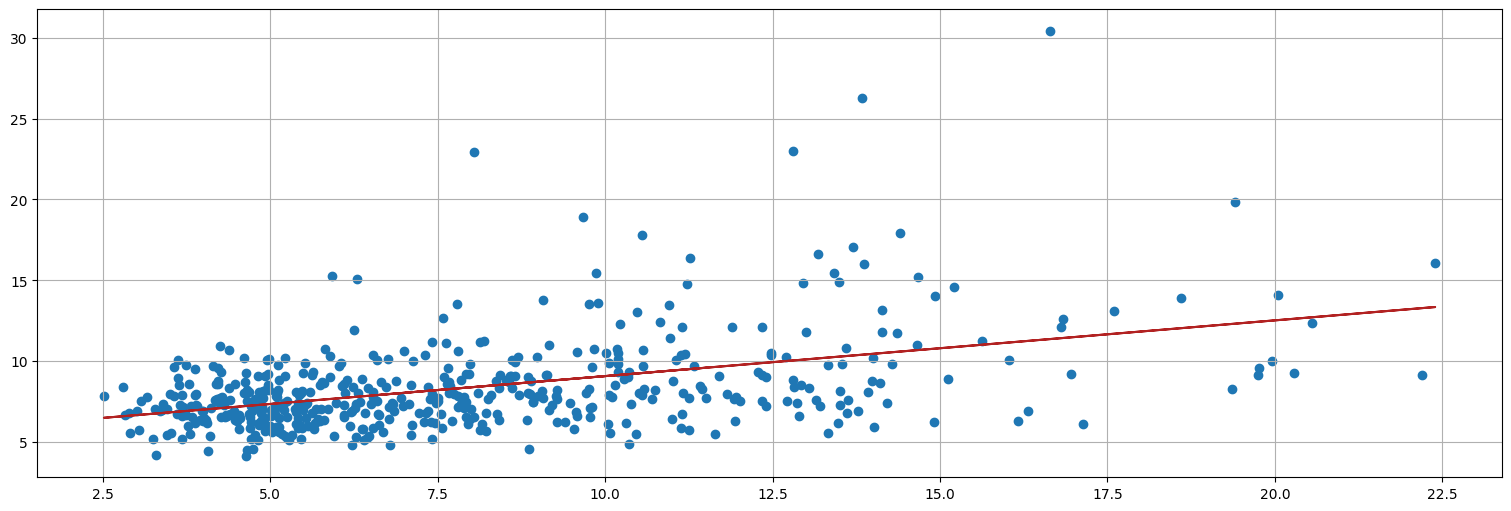

In [84]:
plt.plot(datos.coL7,rmortfit.fittedvalues, color="firebrick")
plt.scatter(co.shift(7), rmort);

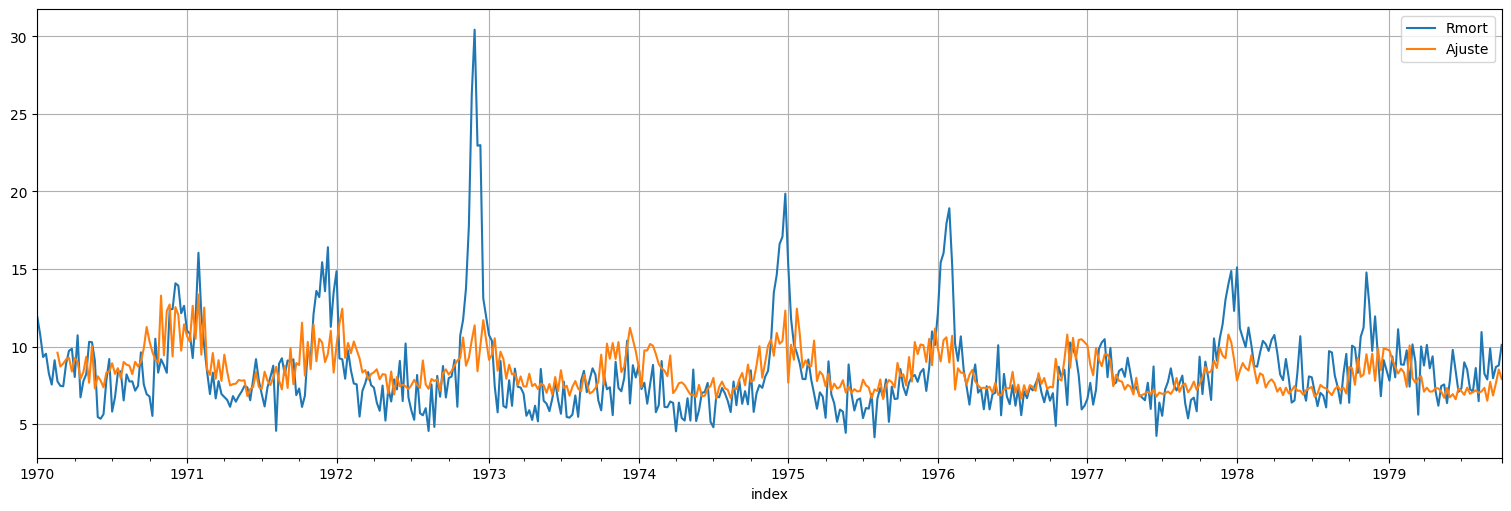

In [85]:
rmort.plot()
rmortfit.fittedvalues.plot().legend(["Rmort","Ajuste"]);

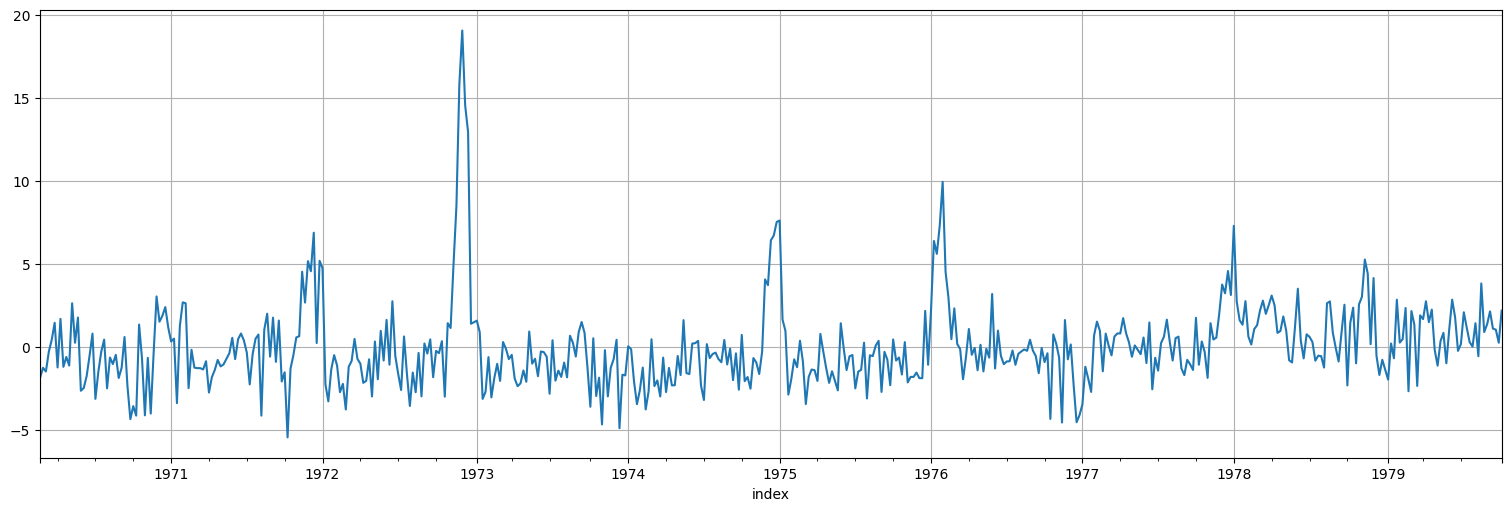

In [96]:
rmortfit_resid.plot();

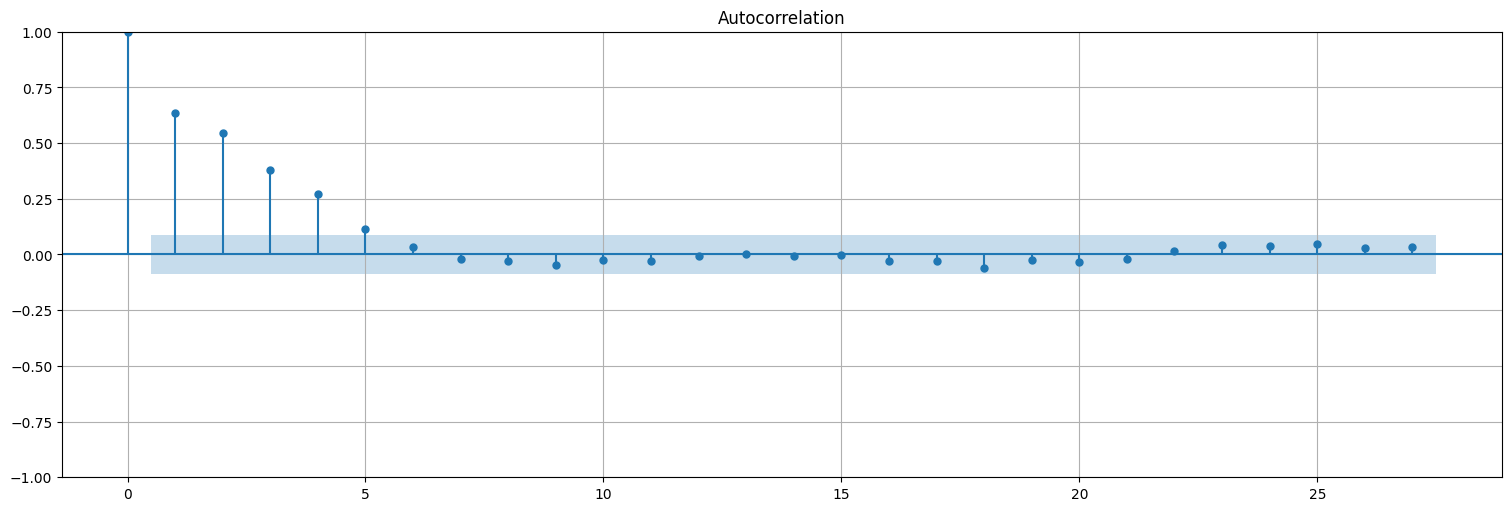

In [97]:
plot_acf(rmortfit_resid,bartlett_confint=False);

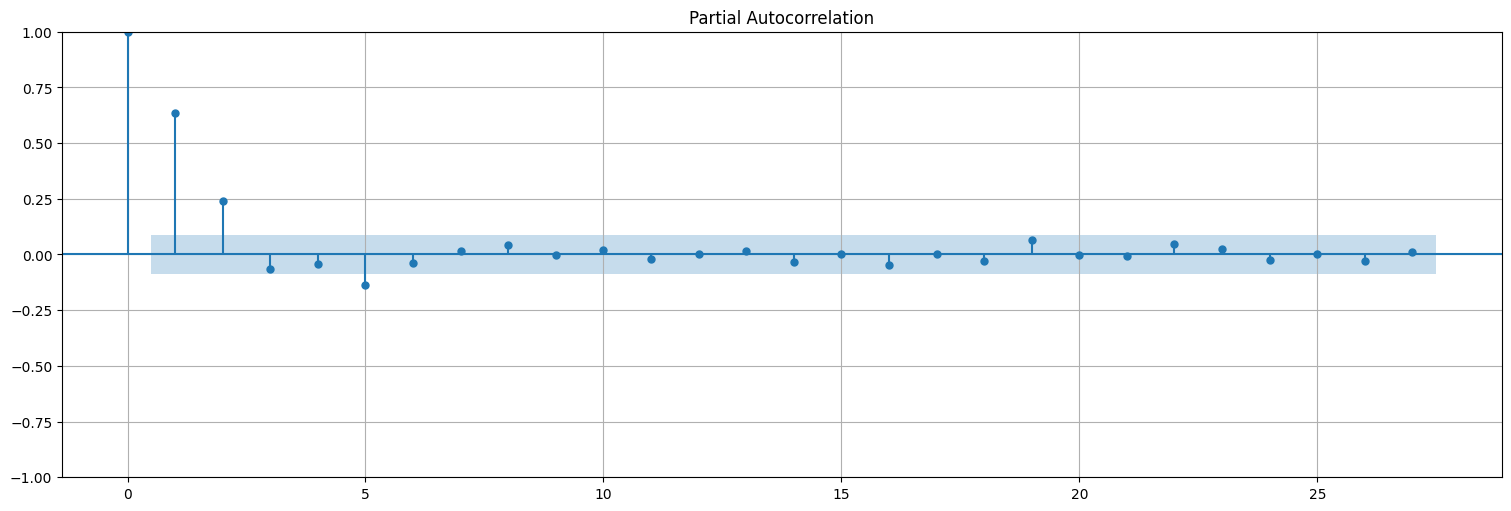

In [104]:
plot_pacf(rmortfit_resid);

In [ ]:
Puede ser un AR(2)